In [1]:
# Description: Plot Figures 5, 6, 7, 9 and 10 and Figures S3-S8.
#
#              - Climatology of cross-isobath heat transports (HT's) and wind stress.
#              - Time series of circumpolarly-integrated HT's and other variables.
#              - Time/along-isobath plots of the mean, eddy and total HT's.
#              - Point-wise correlation between SAM and Niño 3.4 and the total HT.
#              - Time series of heat content and SAM/Niño 3.4 indices.
#              - Lagged correlations between SAM/Niño 3.4 and circumpolar mean and eddy HT's.
#              - Lagged correlations between SAM/Niño 3.4 and segment-averaged total HT's.
#
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        June/2018

import sys
sys.path.append('../../misc')
sys.path.append('../../data_reproduce_figs')
sys.path.append('/home/andre/Dropbox/python-modules/pygamman')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mplpath
from matplotlib import gridspec
from mpl_toolkits.basemap import Basemap
from datetime import datetime
from netCDF4 import Dataset
from pylab import xcorr
import cmocean.cm as cmo
from gsw import f as fcor
import cartopy as ctpy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from pandas import Series, read_csv, Timestamp, date_range, read_table
from pandas import DatetimeIndex, Timedelta
from xarray import open_dataset
from local_utils import blkavg, blkavgt, near2, rcoeff
from local_utils import seasonal_avg, seasonal_std, deseason, lon360to180
from local_utils import crosscorr, Tdecorr, Tdecorrw, rsig, arsig


def _glue_axis1(arr, isep):
    return np.hstack((arr[:, isep:], arr[:, :isep]))


lightgray = [.85]*3
darkgray = [.5]*3
LAND = ctpy.feature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='face', facecolor=darkgray)
def bmap_antarctica_cartopy(ax, labels=False, LAND=LAND):
    ax.add_feature(LAND, zorder=9)
    if labels:
        gl = ax.gridlines(draw_labels=False)
        gl.xlabels_top = gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER

    return ax


def _get_segmsk(x, y, d, seglims, dateline=False):
    xl, xr, yl, yr = seglims
    idxl = near2(x, y, xl, yl, return_index=True)[0]
    idxr = near2(x, y, xr, yr, return_index=True)[0]

    if d[idxl] > d[idxr]:
        idxl, idxr = idxr, idxl

    fseg = np.zeros(x.size)
    if dateline:
        fseg[:idxl] = 1
        fseg[idxr:] = 1
    else:
        fseg[idxl:idxr] = 1

    return np.bool8(fseg)


def crop_scirc(ax, bbox):
    """
    Compute a circle in axes coordinates, which we can use as a boundary
    for the map. We can pan/zoom as much as we like - the boundary will be
    permanently circular.

    Source: http://scitools.org.uk/cartopy/docs/latest/gallery/always_circular_stereo.html#sphx-glr-gallery-always-circular-stereo-py
    """
    ax.set_extent(bbox, ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mplpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)


def bmap_antarctica_fig1(ax, resolution='l'):
    m = Basemap(boundinglat=-60,
                lon_0=60,
                projection='spstere',
                resolution=resolution,
                ax=ax)

    m.fillcontinents(color='0.8', zorder=-9)

    return m

plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

In [2]:
plt.close('all')

DESEASON = True

Wsegs = ['Byrd', 'Amundsen', 'Bellingshausen', 'S-AP', 'N-AP']
Esegs = ['Weddell', 'W-EA', 'C-EA', 'E-EA', 'Ross']
kwleg = dict(fontsize=9, loc='lower left', frameon=False, ncol=5, handlelength=1, handletextpad=0.35, columnspacing=1.0)
kwleg002 = dict(fontsize=10, loc='lower right', frameon=False, ncol=5, handlelength=1.5, handletextpad=0.35, columnspacing=1.0)
kwleg2 = dict(fontsize=13, loc='lower right', frameon=False, ncol=2, handlelength=1, handletextpad=0.35, columnspacing=1.0)

segs_lims = {
'Ross':[165., -150., -79., -68.],
'Byrd':[-150., -130., -79., -68.],
'Amundsen':[-130, -100, -76., -64.],
'Bellingshausen':[-100., -75., -77., -60.],
'S-AP':[-75., -64., -74., -60.],
'N-AP':[-64., -53., -74., -60.],
'Weddell':[-53., -11., -78., -59.],
'W-EA':[-11., 65., -72., -60.],
'C-EA':[65., 100., -72., -60.],
'E-EA':[100., 165., -72., -60.]
}
segnames = segs_lims.keys()

fcap = 501
cm2m = 1e-2
W2TW = 1e-12
rho_sw = 1026.0     # [kg/m3].
cp0 = 39960000.0    # [erg/g/K].
cp0 = cp0*1e-7*1e3  # [J/kg/degC].
T2Q = rho_sw*cp0*W2TW
Tf0 = -2.6431782684654603 # [degC] use the minimum freezing temperature found on the wanted isobath during the entire run.

t_cap = datetime(1958, 1, 1)
head = '../../data_reproduce_figs/'
isob = 1000
fmt = 'png'
kwsavefig = dict(fmt=fmt, bbox_inches='tight', pad_inches=0.0)
TW2GW = 1e3

In [3]:
# Load time-varying heat budget file.
fnamez = head + 'large_files/' + 'hflxmelt_tseries%dm.npz'%isob
headnpz = '../../data_reproduce_figs/'

fnamez_isobs = head + 'isobaths.nc'
ncxm = Dataset(fnamez_isobs)
Im = ncxm["%d m isobath (U-points)"%isob]['i'][:]
Jm = ncxm["%d m isobath (U-points)"%isob]['j'][:]
Umskm = ncxm['%d m isobath (x-isobath U, V masks)'%isob]['Umsk'][:]
Vmskm = ncxm['%d m isobath (x-isobath U, V masks)'%isob]['Vmsk'][:]

dd = np.load(fnamez, encoding='bytes')
for k in dd.keys():
    vars().update({k:dd[k]})

In [4]:
dist = d.copy() # [km].

# Plot mean and eddy components of the circumpolar integral of the heat flux.
ft=t>=t_cap
t = t[ft]

SHT = SHT[ft]
uqx = UQx[ft,:].sum(axis=1)
uqxm = UQxm[ft,:].sum(axis=1)
uqxe = UQxe[ft,:].sum(axis=1)

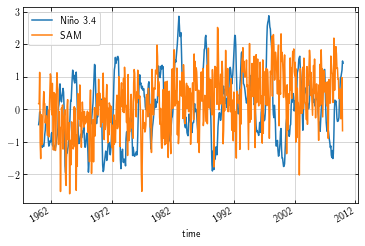

In [5]:
# Load *normalized* Niño 3.4 and SAM from POP forcing.
nino34 = open_dataset(head+'nino34_monthly.nc')['NINO34'].values # Starts in 1960, not 1959.
NINO34 = Series(nino34, index=t[12:])
# Monthly SAM index from corrected CORE-II forcing.
SAM = open_dataset(head+'sam_monthly.nc')['SAM'].to_series()
NINO34.plot(label=r'Niño 3.4')
SAM.plot(label=r'SAM')
plt.legend()

In [6]:
# Cap first 12 months because Niño 3.4 starts in 1960.
UQXM = Series(uqxm, index=t)[12:]
UQXE = Series(uqxe, index=t)[12:]
UQXT = Series(uqx, index=t)[12:]

uqxmsrf = UQxm_100m[ft,:].sum(axis=1)
uqxesrf = UQxe_100m[ft,:].sum(axis=1)
uqxmmid = UQxm_100m_700m[ft,:].sum(axis=1)
uqxemid = UQxe_100m_700m[ft,:].sum(axis=1)
uqxmbot = UQxm_700m_1000m[ft,:].sum(axis=1)
uqxebot = UQxe_700m_1000m[ft,:].sum(axis=1)
uqx_nonssn = deseason(t, uqx)
uqxm_nonssn = deseason(t, uqxm)
uqxe_nonssn = deseason(t, uqxe)#uqx_nonssn - uqxm_nonssn

blk = 12
# Annual averages.
_, yruqxm_nonssn, yruqxm_nonssn_std = blkavgt(t, uqxm_nonssn, every=blk)
tb, yruqxe_nonssn, yruqxe_nonssn_std = blkavgt(t, uqxe_nonssn, every=blk)
yruqx_nonssn = yruqxm_nonssn + yruqxe_nonssn

blk2 = blk

In [7]:
yrUQx = np.zeros((tb.size, d.size))
yrUQxm = yrUQx.copy()
yrUQxe = yrUQx.copy()

if DESEASON:
    for n in range(d.size):
        _, yrUQx[:,n], _ = blkavgt(t, deseason(t, UQx[:,n]), every=blk2)
        _, yrUQxm[:,n], _ = blkavgt(t, deseason(t, UQxm[:,n]), every=blk2)
        _, yrUQxe[:,n], _ = blkavgt(t, deseason(t, UQxe[:,n]), every=blk2)
else:
    for n in range(d.size):
        _, yrUQx[:,n], _ = blkavgt(t, UQx[:,n], every=blk2)
        _, yrUQxm[:,n], _ = blkavgt(t, UQxm[:,n], every=blk2)
        _, yrUQxe[:,n], _ = blkavgt(t, UQxe[:,n], every=blk2)

tb, _, _ = blkavgt(t, UQx[:,0], every=blk2)
for n in range(d.size):
    _, yrUQx[:,n], _ = blkavgt(t, UQx[:,n], every=blk2)
    _, yrUQxm[:,n], _ = blkavgt(t, UQxm[:,n], every=blk2)
    _, yrUQxe[:,n], _ = blkavgt(t, UQxe[:,n], every=blk2)

Lx = 50         # [km], Desired size for each block.
dx = 3.28971284 # [km].
blkx = int(Lx/dx)
davg, _, _ = blkavg(d, yrUQx[:,0], every=blkx)
xavg, _, _ = blkavg(x, yrUQx[:,0], every=blkx)
yrUQx_avgx = np.zeros((tb.size, davg.size))
yrUQxm_avgx = yrUQx_avgx.copy()
yrUQxe_avgx = yrUQx_avgx.copy()

for m in range(tb.size):
    _, yrUQx_avgx[m,:], _ = blkavg(d, yrUQx[m,:], every=blkx)
    _, yrUQxm_avgx[m,:], _ = blkavg(d, yrUQxm[m,:], every=blkx)
    _, yrUQxe_avgx[m,:], _ = blkavg(d, yrUQxe[m,:], every=blkx)

UQx_avgx = np.zeros((t.size, davg.size))
UQxm_avgx = UQx_avgx.copy()
UQxe_avgx = UQx_avgx.copy()
for m in range(t.size):
    _, UQx_avgx[m,:], _ = blkavg(d, UQx[m,:], every=blkx)
    _, UQxm_avgx[m,:], _ = blkavg(d, UQxm[m,:], every=blkx)
    _, UQxe_avgx[m,:], _ = blkavg(d, UQxe[m,:], every=blkx)

In [8]:
vmim, vmam = -0.5, 0.5

# Load model topography.
ftopo = head + 'POP_topog.nc'
nctopo = Dataset(ftopo).variables
lont, latt, ht = nctopo['TLONG'][:fcap,:], nctopo['TLAT'][:fcap,:], nctopo['HT'][:fcap,:]*1e-2
lonu, latu = nctopo['ULONG'][:fcap,:], nctopo['ULAT'][:fcap,:]
lont = lon360to180(lont)
lonu = lon360to180(lonu)

In [9]:
# Load model grid variables.

fname_dzt = head + 'POP-dzu_dzt_kzit_subsetSO.nc'
ncg = Dataset(fname_dzt)
DZT0 = ncg.variables['dzt'][:,:fcap,:]*cm2m
dztm = DZT0[:, Im, Jm]
ncdxy = Dataset(head+'large_files/'+'SOsubset_avg_2005-2009.nc')
DXU = ncdxy.variables['DXU'][:fcap,:]*cm2m
DYU = ncdxy.variables['DYU'][:fcap,:]*cm2m

In [10]:
# lon, lat, ht must start at -180 to plot contour.
fcut = np.where(np.abs(np.diff(lont[0,:]))>10)[0][0] + 1
lont = _glue_axis1(lont, fcut)
latt = _glue_axis1(latt, fcut)
lonu = _glue_axis1(lonu, fcut)
latu = _glue_axis1(latu, fcut)
ht = _glue_axis1(ht, fcut)

yrUQx_avgx = _glue_axis1(yrUQx_avgx, fcut)
yrUQxm_avgx = _glue_axis1(yrUQxm_avgx, fcut)
yrUQxe_avgx = _glue_axis1(yrUQxe_avgx, fcut)

dztm = DZT0[:, Im, Jm]
dztm_1pp1 = dztm[1:-1]

In [11]:
###########################################
## Monthly- and yearly-averaged transports.
###########################################
blk = 12 # [months].

tb, yruqxm, yruqxm_std = blkavgt(t, uqxm, every=blk)
_, yruqxe, yruqxe_std = blkavgt(t, uqxe, every=blk)
_, yruqx, yruqx_std = blkavgt(t, uqx, every=blk)
tb, Qmyr, Qmyr_std = blkavgt(t, Qm, every=12)

_, yruqxmsrf, yruqxmsrf_std = blkavgt(t, uqxmsrf, every=blk)
_, yruqxesrf, yruqxesrf_std = blkavgt(t, uqxesrf, every=blk)
_, yruqxmmid, yruqxmmid_std = blkavgt(t, uqxmmid, every=blk)
_, yruqxemid, yruqxemid_std = blkavgt(t, uqxemid, every=blk)
_, yruqxmbot, yruqxmbot_std = blkavgt(t, uqxmbot, every=blk)
_, yruqxebot, yruqxebot_std = blkavgt(t, uqxebot, every=blk)

In [12]:
#-----------------------------------------------------------
# Time series of yearly time averages of the heat transports
# averaged along each segment.
#-----------------------------------------------------------

# Calculate segment-averaged heat transports.
yruqxmseg_avg = dict()
yruqxeseg_avg = dict()
yruqxseg_avg = dict()
#
uqxseg_avg = dict()
uqxmseg_avg = dict()
uqxeseg_avg = dict()

kwlegg1 = dict(fontsize=10, loc='lower left', frameon=False, ncol=5, handlelength=1, handletextpad=0.35, columnspacing=1.0)
kwlegg2 = dict(fontsize=10, loc='lower right', frameon=False, ncol=5, handlelength=1, handletextpad=0.35, columnspacing=1.0)
kwlegg3 = dict(fontsize=10, loc='upper left', frameon=False, ncol=5, handlelength=1, handletextpad=0.35, columnspacing=1.0)
kwlegg4 = dict(fontsize=10, loc='lower right', frameon=False, ncol=5, handlelength=1, handletextpad=0.35, columnspacing=1.0)
kwlegg5 = dict(fontsize=10, loc='lower right', frameon=False, ncol=5, handlelength=1, handletextpad=0.35, columnspacing=1.0)
kwlegg6 = dict(fontsize=10, loc='upper left', frameon=False, ncol=5, handlelength=1, handletextpad=0.35, columnspacing=1.0)

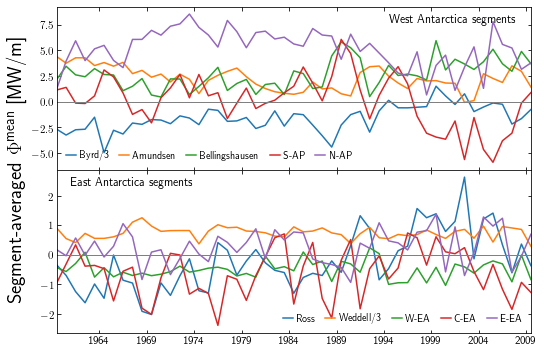

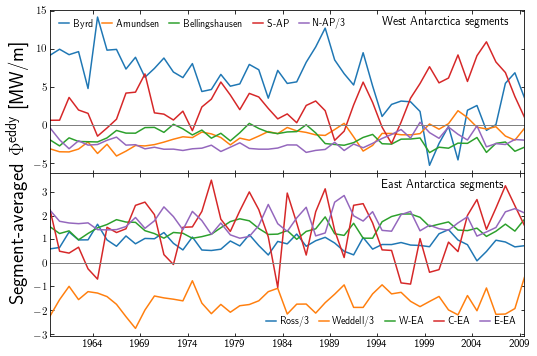

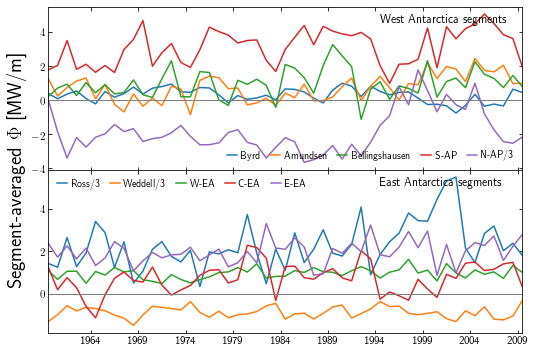

In [13]:
###########################################################################
# Plot Figures S4, S5 and S6 (time series of segment-averaged components  #
# of the heat transport across the 1000 m isobath (total, mean and eddy). #
###########################################################################

phi_dfac = 3
phim_dfac = 3
phie_dfac = 3
figsize_phis = (8.5, 6)
fig12, axx = plt.subplots(figsize=figsize_phis, nrows=2, sharex=True)
ax1, ax2 = axx
fig34, axx = plt.subplots(figsize=figsize_phis, nrows=2, sharex=True)
ax3, ax4 = axx
fig56, axx = plt.subplots(figsize=figsize_phis, nrows=2, sharex=True)
ax5, ax6 = axx
for seg in segs_lims.keys():
    lol, lor = segs_lims[seg][:2]
    if seg=='Ross':
        fseg = _get_segmsk(x, y, dist, segs_lims[seg], dateline=True)
        aux = dist[fseg]
        fmid = np.diff(aux).argmax()
        Lxseg = aux[fmid] + aux[-1] - aux[fmid+1] # 180 to 165 plus -150 to -180.
    else:
        fseg = _get_segmsk(x, y, dist, segs_lims[seg], dateline=False)
        aux = dist[fseg]
        Lxseg = aux[-1] - aux[0]

    uqxmseg = UQxm[:,fseg].sum(axis=1)*TW2GW/Lxseg # Mean, [MW/m].
    uqxeseg = UQxe[:,fseg].sum(axis=1)*TW2GW/Lxseg # Eddy, [MW/m].
    uqxseg = UQx[:,fseg].sum(axis=1)*TW2GW/Lxseg   # Total, [MW/m].

    _, yruqxmseg, _ = blkavgt(t, uqxmseg, every=blk)
    tb, yruqxeseg, _ = blkavgt(t, uqxeseg, every=blk)
    yruqxseg = yruqxmseg + yruqxeseg

    yruqxseg_avg.update({seg:yruqxseg})
    yruqxmseg_avg.update({seg:yruqxmseg})
    yruqxeseg_avg.update({seg:yruqxeseg})
    #
    uqxseg_avg.update({seg:uqxseg})
    uqxmseg_avg.update({seg:uqxmseg})
    uqxeseg_avg.update({seg:uqxeseg})

    if seg in ['Weddell', 'Byrd']:
        yruqxsegplt = yruqxseg/phim_dfac
        seglabelm = seg + '/%d'%phi_dfac
    else:
        yruqxsegplt = yruqxseg.copy()
        seglabelm = seg

    if seg in ['Weddell', 'Byrd']:
        yruqxmsegplt = yruqxmseg/phim_dfac
        seglabelm = seg + '/%d'%phim_dfac
    else:
        yruqxmsegplt = yruqxmseg.copy()
        seglabelm = seg

    if seg in ['N-AP', 'Ross', 'Weddell']:
        yruqxesegplt = yruqxeseg/phie_dfac
        seglabele = seg + '/%d'%phie_dfac
    else:
        yruqxesegplt = yruqxeseg.copy()
        seglabele = seg

    if seg in Wsegs:
        ax1.plot(tb, yruqxmsegplt, linewidth=1.5, label=seglabelm)
        ax3.plot(tb, yruqxesegplt, linewidth=1.5, label=seglabele)
        ax5.plot(tb, yruqxsegplt, linewidth=1.5, label=seglabele)
    if seg in Esegs:
        ax2.plot(tb, yruqxmsegplt, linewidth=1.5, label=seglabelm)
        ax4.plot(tb, yruqxesegplt, linewidth=1.5, label=seglabele)
        ax6.plot(tb, yruqxsegplt, linewidth=1.5, label=seglabele)

ax1.set_ylabel(r'Segment-averaged $\Phi^\text{mean}$ [MW/m]', fontsize=20, y=0)
ax3.set_ylabel(r'Segment-averaged $\Phi^\text{eddy}$ [MW/m]', fontsize=20, y=0)
ax5.set_ylabel(r'Segment-averaged $\Phi$ [MW/m]', fontsize=20, y=0)
ax1.legend(**kwlegg1)
ax2.legend(**kwlegg2)
ax3.legend(**kwlegg3)
ax4.legend(**kwlegg4)
ax5.legend(**kwlegg5)
ax6.legend(**kwlegg6)

ax1.set_xlim(tb[0], tb[-1])
fig12.subplots_adjust(hspace=0.025)
ax3.set_xlim(tb[0], tb[-1])
fig34.subplots_adjust(hspace=0.025)
ax5.set_xlim(tb[0], tb[-1])
fig56.subplots_adjust(hspace=0.025)

ax1.xaxis.set_tick_params(labelsize=11, labelbottom=False, pad=3)
ax3.xaxis.set_tick_params(labelsize=11, labelbottom=False, pad=3)
ax5.xaxis.set_tick_params(labelsize=11, labelbottom=False, pad=3)
ax2.xaxis.set_tick_params(labelsize=11, pad=3)
ax4.xaxis.set_tick_params(labelsize=11, pad=3)
ax6.xaxis.set_tick_params(labelsize=11, pad=3)
#
ax1.yaxis.set_tick_params(labelsize=11, pad=3)
ax2.yaxis.set_tick_params(labelsize=11, pad=3)
ax3.yaxis.set_tick_params(labelsize=11, pad=3)
ax4.yaxis.set_tick_params(labelsize=11, pad=3)
ax5.yaxis.set_tick_params(labelsize=11, pad=3)
ax6.yaxis.set_tick_params(labelsize=11, pad=3)
#
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax4.grid(False)
ax5.grid(False)
ax6.grid(False)
#
xts134, yts134 = 0.70, 0.90
xts2, yts2 = 0.03, 0.90
ax1.text(xts134, yts134, r'West Antarctica segments', fontsize=12, fontweight='bold', zorder=10, transform=ax1.transAxes)
ax3.text(xts134, yts134, r'West Antarctica segments', fontsize=12, fontweight='bold', zorder=10, transform=ax3.transAxes)
ax5.text(xts134, yts134, r'West Antarctica segments', fontsize=12, fontweight='bold', zorder=10, transform=ax5.transAxes)
ax2.text(xts2, yts2, r'East Antarctica segments', fontsize=12, fontweight='bold', zorder=10, transform=ax2.transAxes)
ax4.text(xts134, yts134, r'East Antarctica segments', fontsize=12, fontweight='bold', zorder=10, transform=ax4.transAxes)
ax6.text(xts134, yts134, r'East Antarctica segments', fontsize=12, fontweight='bold', zorder=10, transform=ax6.transAxes)
#
ax1.axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax2.axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax3.axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax4.axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax5.axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax6.axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
#
ax1.legend(**kwlegg1)
ax2.legend(**kwlegg2)
ax3.legend(**kwlegg3)
ax4.legend(**kwlegg4)
ax5.legend(**kwlegg5)
ax6.legend(**kwlegg6)

fig12.subplots_adjust(hspace=0)
fig34.subplots_adjust(hspace=0)
fig56.subplots_adjust(hspace=0)

fig12.savefig('figS_UQxmean.eps')
fig34.savefig('figS_UQxeddy.eps')
fig56.savefig('figS_UQxtotal.eps')

fig12.savefig('figS_UQxmean.png')
fig34.savefig('figS_UQxeddy.png')
fig56.savefig('figS_UQxtotal.png')

plt.show()

In [14]:
# Check correlations between SAM and Niño 3.4 index and heat transport on each segment.
alpha1 = 0.80
alpha2 = 0.95
nblksnino34, nblkssam = 23, 23

uqxseg_avg_nino34, uqxmseg_avg_nino34, uqxeseg_avg_nino34 = dict(), dict(), dict()
uqxseg_avg_sam, uqxmseg_avg_sam, uqxeseg_avg_sam = dict(), dict(), dict()
for seg in segnames:
    uqxseg_avg_nino34.update({seg:uqxseg_avg[seg][12:]})
    uqxmseg_avg_nino34.update({seg:uqxmseg_avg[seg][12:]})
    uqxeseg_avg_nino34.update({seg:uqxeseg_avg[seg][12:]})
    #
    uqxseg_avg_sam.update({seg:uqxseg_avg[seg][12:-1]}) # Monthly SAM misses dec/2009.
    uqxmseg_avg_sam.update({seg:uqxmseg_avg[seg][12:-1]})
    uqxeseg_avg_sam.update({seg:uqxeseg_avg[seg][12:-1]})

# NIÑO 3.4-UQ EDoFs and SAM 3.4-UQ EDoFs vary, depending on segment and mean, eddy or total transport.

Rnino34_uqxt, Rnino34_uqxm, Rnino34_uqxe = dict(), dict(), dict()
Rsam_uqxt, Rsam_uqxm, Rsam_uqxe = dict(), dict(), dict()
for seg in segnames:
    lagsnino34, rnino34_uqxt = crosscorr(NINO34, uqxseg_avg_nino34[seg], nblksnino34)
    lagsnino34, rnino34_uqxm = crosscorr(NINO34, uqxmseg_avg_nino34[seg], nblksnino34)
    lagsnino34, rnino34_uqxe = crosscorr(NINO34, uqxeseg_avg_nino34[seg], nblksnino34)
    lagssam, rsam_uqxt = crosscorr(SAM, uqxseg_avg_sam[seg], nblkssam)
    lagssam, rsam_uqxm = crosscorr(SAM, uqxmseg_avg_sam[seg], nblkssam)
    lagssam, rsam_uqxe = crosscorr(SAM, uqxeseg_avg_sam[seg], nblkssam)

    Rnino34_uqxt.update({seg:rnino34_uqxt})
    Rnino34_uqxm.update({seg:rnino34_uqxm})
    Rnino34_uqxe.update({seg:rnino34_uqxe})
    Rsam_uqxt.update({seg:rsam_uqxt})
    Rsam_uqxm.update({seg:rsam_uqxm})
    Rsam_uqxe.update({seg:rsam_uqxe})

    f1 = np.abs(rnino34_uqxt).argmax()
    f2 = np.abs(rnino34_uqxm).argmax()
    f3 = np.abs(rnino34_uqxe).argmax()
    uqxtlagmax = lagsnino34[f1]
    uqxmlagmax = lagsnino34[f2]
    uqxelagmax = lagsnino34[f3]
    print('============ %s ============'%seg)
    print('Max correlation = %1.3f at %d months lag for UQt - Nino 3.4'%(rnino34_uqxt[f1],uqxtlagmax))
    print('Max correlation = %1.3f for %d months lag UQm - Nino 3.4'%(rnino34_uqxm[f2],uqxmlagmax))
    print('Max correlation = %1.3f for %d months lag UQe - Nino 3.4'%(rnino34_uqxe[f3],uqxelagmax))
    print('')

    f1 = np.abs(rsam_uqxt).argmax()
    f2 = np.abs(rsam_uqxm).argmax()
    f3 = np.abs(rsam_uqxe).argmax()
    uqxtlagmax_sam = lagssam[f1]
    uqxmlagmax_sam = lagssam[f2]
    uqxelagmax_sam = lagssam[f3]
    print('============ %s ============'%seg)
    print('Max correlation = %1.3f at %d months lag for UQt - SAM'%(rsam_uqxt[f1],uqxtlagmax_sam))
    print('Max correlation = %1.3f for %d months lag UQm - SAM'%(rsam_uqxm[f2],uqxmlagmax_sam))
    print('Max correlation = %1.3f for %d months lag UQe - SAM'%(rsam_uqxe[f3],uqxelagmax_sam))
    print('')

============ Ross ============
Max correlation = 0.200 at -23 months lag for UQt - Nino 3.4
Max correlation = 0.252 for -22 months lag UQm - Nino 3.4
Max correlation = 0.217 for -24 months lag UQe - Nino 3.4

============ Ross ============
Max correlation = 0.304 at -24 months lag for UQt - SAM
Max correlation = -0.213 for -20 months lag UQm - SAM
Max correlation = -0.195 for 22 months lag UQe - SAM

============ Byrd ============
Max correlation = -0.199 at -12 months lag for UQt - Nino 3.4
Max correlation = 0.304 for -24 months lag UQm - Nino 3.4
Max correlation = 0.224 for -23 months lag UQe - Nino 3.4

============ Byrd ============
Max correlation = 0.177 at 22 months lag for UQt - SAM
Max correlation = 0.254 for -23 months lag UQm - SAM
Max correlation = 0.478 for 24 months lag UQe - SAM

============ Amundsen ============
Max correlation = 0.304 at 24 months lag for UQt - Nino 3.4
Max correlation = 0.296 for 23 months lag UQm - Nino 3.4
Max correlation = 0.217 for -24 months lag

In [15]:
# Check EDoFs for:
# uqx, uqxm and uqxe in each segment, and the NIÑO 3.4 index from POP.
arsegstTi, arsegsmTi, arsegseTi = dict(), dict(), dict()
for seg in segnames:
    arsegstTi.update({seg:max(Tdecorr(crosscorr(uqxseg_avg_nino34[seg], uqxseg_avg_nino34[seg], nblksnino34)[1]))})
    arsegsmTi.update({seg:max(Tdecorr(crosscorr(uqxmseg_avg_nino34[seg], uqxmseg_avg_nino34[seg], nblksnino34)[1]))})
    arsegseTi.update({seg:max(Tdecorr(crosscorr(uqxeseg_avg_nino34[seg], uqxeseg_avg_nino34[seg], nblksnino34)[1]))})
lagsnino34a, arnino34 = crosscorr(NINO34, NINO34, nblksnino34)
Tarnino34 = Tdecorr(arnino34).max()

Tit, Tim, Tie = dict(), dict(), dict()
EDoFtnino34, EDoFmnino34, EDoFenino34 = dict(), dict(), dict()
rsig1tnino34, rsig1mnino34, rsig1enino34 = dict(), dict(), dict()
rsig2tnino34, rsig2mnino34, rsig2enino34 =  dict(), dict(), dict()
nTinino34 = uqxseg_avg_nino34[seg].size
Nsamplesnino34 = lagsnino34.max()*np.ones(lagsnino34.size) - np.abs(lagsnino34) # Less nino34ples at larger lags.
for seg in segnames:
    Tit.update({seg:np.max([arsegstTi[seg], Tarnino34])})
    Tim.update({seg:np.max([arsegsmTi[seg], Tarnino34])})
    Tie.update({seg:np.max([arsegseTi[seg], Tarnino34])})
    #
    nnino34t = (Nsamplesnino34/Tit[seg])*nblksnino34
    nnino34m = (Nsamplesnino34/Tim[seg])*nblksnino34
    nnino34e = (Nsamplesnino34/Tie[seg])*nblksnino34
    #
    EDoFtnino34.update({seg:nnino34t})
    EDoFmnino34.update({seg:nnino34m})
    EDoFenino34.update({seg:nnino34e})

    print("=============== %s ==============="%seg)
    print("EDoF for UQxt and Niño 3.4 (at zero lag): %f"%EDoFtnino34[seg].max())
    print("EDoF for UQxm and Niño 3.4 (at zero lag): %f"%EDoFmnino34[seg].max())
    print("EDoF for UQxe and Niño 3.4 (at zero lag): %f"%EDoFenino34[seg].max())
    rsig1tnino34.update({seg:rsig(EDoFtnino34[seg], alpha=alpha1)})
    rsig1mnino34.update({seg:rsig(EDoFmnino34[seg], alpha=alpha1)})
    rsig1enino34.update({seg:rsig(EDoFenino34[seg], alpha=alpha1)})
    #
    rsig2tnino34.update({seg:rsig(EDoFtnino34[seg], alpha=alpha2)})
    rsig2mnino34.update({seg:rsig(EDoFmnino34[seg], alpha=alpha2)})
    rsig2enino34.update({seg:rsig(EDoFenino34[seg], alpha=alpha2)})

=============== Ross ===============
EDoF for UQxt and Niño 3.4 (at zero lag): 211.926842
EDoF for UQxm and Niño 3.4 (at zero lag): 211.926842
EDoF for UQxe and Niño 3.4 (at zero lag): 211.926842
=============== Byrd ===============
EDoF for UQxt and Niño 3.4 (at zero lag): 211.926842
EDoF for UQxm and Niño 3.4 (at zero lag): 211.926842
EDoF for UQxe and Niño 3.4 (at zero lag): 211.926842
=============== Amundsen ===============
EDoF for UQxt and Niño 3.4 (at zero lag): 211.926842
EDoF for UQxm and Niño 3.4 (at zero lag): 211.926842
EDoF for UQxe and Niño 3.4 (at zero lag): 211.926842
=============== Bellingshausen ===============
EDoF for UQxt and Niño 3.4 (at zero lag): 211.926842
EDoF for UQxm and Niño 3.4 (at zero lag): 211.926842
EDoF for UQxe and Niño 3.4 (at zero lag): 211.926842
=============== S-AP ===============
EDoF for UQxt and Niño 3.4 (at zero lag): 211.926842
EDoF for UQxm and Niño 3.4 (at zero lag): 211.926842
EDoF for UQxe and Niño 3.4 (at zero lag): 211.926842
======

In [16]:
# Check EDoFs for:
# uqx, uqxm and uqxe in each segment, and the SAM index from POP.
arsegstTi, arsegsmTi, arsegseTi = dict(), dict(), dict()
for seg in segnames:
    arsegstTi.update({seg:max(Tdecorr(crosscorr(uqxseg_avg_sam[seg], uqxseg_avg_sam[seg], nblkssam)[1]))})
    arsegsmTi.update({seg:max(Tdecorr(crosscorr(uqxmseg_avg_sam[seg], uqxmseg_avg_sam[seg], nblkssam)[1]))})
    arsegseTi.update({seg:max(Tdecorr(crosscorr(uqxeseg_avg_sam[seg], uqxeseg_avg_sam[seg], nblkssam)[1]))})
lagssama, arsam = crosscorr(SAM, SAM, nblkssam)
Tarsam = Tdecorr(arsam).max()

Tit, Tim, Tie = dict(), dict(), dict()
EDoFtsam, EDoFmsam, EDoFesam = dict(), dict(), dict()
rsig1tsam, rsig1msam, rsig1esam = dict(), dict(), dict()
rsig2tsam, rsig2msam, rsig2esam =  dict(), dict(), dict()
nTisam = uqxseg_avg_sam[seg].size
Nsamplessam = lagssam.max()*np.ones(lagssam.size) - np.abs(lagssam) # Less samples at larger lags.
for seg in segnames:
    Tit.update({seg:np.max([arsegstTi[seg], Tarsam])})
    Tim.update({seg:np.max([arsegsmTi[seg], Tarsam])})
    Tie.update({seg:np.max([arsegseTi[seg], Tarsam])})
    #
    nsamt = (Nsamplessam/Tit[seg])*nblkssam
    nsamm = (Nsamplessam/Tim[seg])*nblkssam
    nsame = (Nsamplessam/Tie[seg])*nblkssam
    #
    EDoFtsam.update({seg:nsamt})
    EDoFmsam.update({seg:nsamm})
    EDoFesam.update({seg:nsame})

    print("=============== %s ==============="%seg)
    print("EDoF for UQxt and SAM (at zero lag): %f"%EDoFtsam[seg].max())
    print("EDoF for UQxm and SAM (at zero lag): %f"%EDoFmsam[seg].max())
    print("EDoF for UQxe and SAM (at zero lag): %f"%EDoFesam[seg].max())
    rsig1tsam.update({seg:rsig(EDoFtsam[seg], alpha=alpha1)})
    rsig1msam.update({seg:rsig(EDoFmsam[seg], alpha=alpha1)})
    rsig1esam.update({seg:rsig(EDoFesam[seg], alpha=alpha1)})
    #
    rsig2tsam.update({seg:rsig(EDoFtsam[seg], alpha=alpha2)})
    rsig2msam.update({seg:rsig(EDoFmsam[seg], alpha=alpha2)})
    rsig2esam.update({seg:rsig(EDoFesam[seg], alpha=alpha2)})

=============== Ross ===============
EDoF for UQxt and SAM (at zero lag): 408.671034
EDoF for UQxm and SAM (at zero lag): 451.935083
EDoF for UQxe and SAM (at zero lag): 424.871490
=============== Byrd ===============
EDoF for UQxt and SAM (at zero lag): 406.836905
EDoF for UQxm and SAM (at zero lag): 451.935083
EDoF for UQxe and SAM (at zero lag): 307.543248
=============== Amundsen ===============
EDoF for UQxt and SAM (at zero lag): 373.332158
EDoF for UQxm and SAM (at zero lag): 451.935083
EDoF for UQxe and SAM (at zero lag): 451.935083
=============== Bellingshausen ===============
EDoF for UQxt and SAM (at zero lag): 366.516984
EDoF for UQxm and SAM (at zero lag): 367.233353
EDoF for UQxe and SAM (at zero lag): 451.935083
=============== S-AP ===============
EDoF for UQxt and SAM (at zero lag): 451.935083
EDoF for UQxm and SAM (at zero lag): 308.330333
EDoF for UQxe and SAM (at zero lag): 451.935083
=============== N-AP ===============
EDoF for UQxt and SAM (at zero lag): 451.935

In [17]:
# SAM and circumpolar mean/eddy HT.
Tim_circ = np.maximum(Tdecorr(crosscorr(uqxm, uqxm, nblkssam)[1]).max(), Tarsam)
Tie_circ = np.maximum(Tdecorr(crosscorr(uqxe, uqxe, nblkssam)[1]).max(), Tarsam)
nsamm_circ = (Nsamplessam/Tim_circ)*nblkssam
nsame_circ = (Nsamplessam/Tie_circ)*nblkssam

rsig1msam_circ = rsig(nsamm_circ, alpha=alpha1)
rsig1esam_circ = rsig(nsame_circ, alpha=alpha1)
rsig2msam_circ = rsig(nsamm_circ, alpha=alpha2)
rsig2esam_circ = rsig(nsame_circ, alpha=alpha2)

# Niño 3.4 and circumpolar mean/eddy HT.
Tim_circ = np.maximum(Tdecorr(crosscorr(uqxm, uqxm, nblkssam)[1]).max(), Tarnino34)
Tie_circ = np.maximum(Tdecorr(crosscorr(uqxe, uqxe, nblkssam)[1]).max(), Tarnino34)
nnino34m_circ = (Nsamplesnino34/Tim_circ)*nblksnino34
nnino34e_circ = (Nsamplesnino34/Tie_circ)*nblksnino34

rsig1mnino34_circ = rsig(nnino34m_circ, alpha=alpha1)
rsig1enino34_circ = rsig(nnino34e_circ, alpha=alpha1)
rsig2mnino34_circ = rsig(nnino34m_circ, alpha=alpha2)
rsig2enino34_circ = rsig(nnino34e_circ, alpha=alpha2)

Text(0.5,1,'Correlation between $\\Phi^\\text{eddy}$ and POP2/CICE4 SAM index')

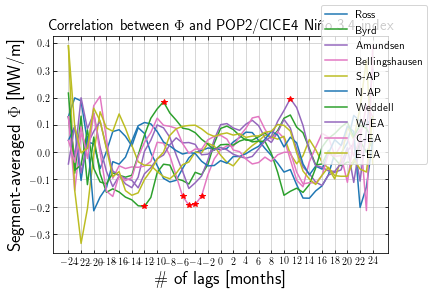

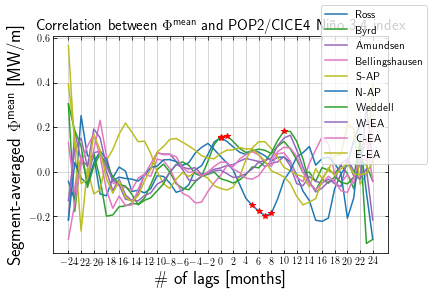

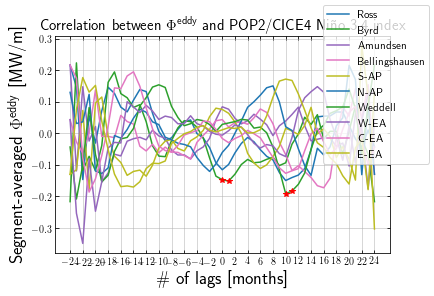

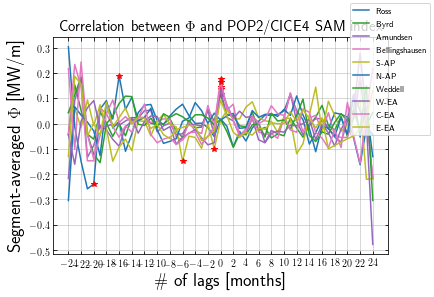

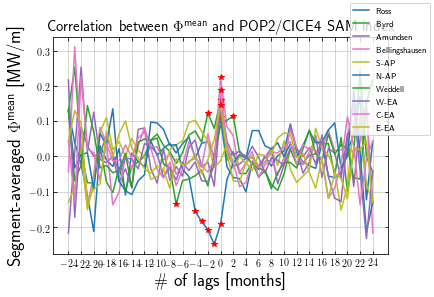

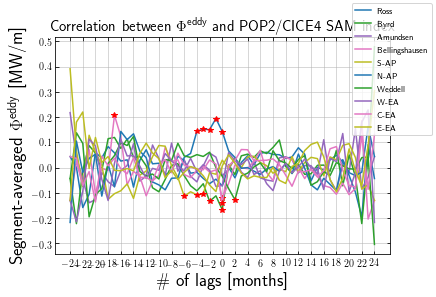

In [18]:
fig, ax = plt.subplots()
figm, axm = plt.subplots()
fige, axe = plt.subplots()
fig_sam, ax_sam = plt.subplots()
figm_sam, axm_sam = plt.subplots()
fige_sam, axe_sam = plt.subplots()
alphalines = 1
for seg in segnames:
    rnino34_uqxt = Rnino34_uqxt[seg]
    rnino34_uqxm = Rnino34_uqxm[seg]
    rnino34_uqxe = Rnino34_uqxe[seg]
    rsam_uqxt = Rsam_uqxt[seg]
    rsam_uqxm = Rsam_uqxm[seg]
    rsam_uqxe = Rsam_uqxe[seg]
    #
    ax.plot(lagsnino34, rnino34_uqxt, alpha=alphalines, label=seg)
    axm.plot(lagsnino34, rnino34_uqxm, alpha=alphalines, label=seg)
    axe.plot(lagsnino34, rnino34_uqxe, alpha=alphalines, label=seg)
    #
    ax_sam.plot(lagssam, rsam_uqxt, alpha=alphalines, label=seg)
    axm_sam.plot(lagssam, rsam_uqxm, alpha=alphalines, label=seg)
    axe_sam.plot(lagssam, rsam_uqxe, alpha=alphalines, label=seg)
    #
    # Next, mark only the statistically significant points.
    fsignino34t = np.logical_or(rnino34_uqxt>=rsig2tnino34[seg], rnino34_uqxt<=-rsig2tnino34[seg])
    fsignino34m = np.logical_or(rnino34_uqxm>=rsig2mnino34[seg], rnino34_uqxm<=-rsig2mnino34[seg])
    fsignino34e = np.logical_or(rnino34_uqxe>=rsig2enino34[seg], rnino34_uqxe<=-rsig2enino34[seg])
    #
    fsigsamt = np.logical_or(rsam_uqxt>=rsig2tsam[seg], rsam_uqxt<=-rsig2tsam[seg])
    fsigsamm = np.logical_or(rsam_uqxm>=rsig2msam[seg], rsam_uqxm<=-rsig2msam[seg])
    fsigsame = np.logical_or(rsam_uqxe>=rsig2esam[seg], rsam_uqxe<=-rsig2esam[seg])
    ##
    ax.plot(lagsnino34[fsignino34t], rnino34_uqxt[fsignino34t], linestyle='none', marker='*', mfc='r', mec='r')
    axm.plot(lagsnino34[fsignino34m], rnino34_uqxm[fsignino34m], linestyle='none', marker='*', mfc='r', mec='r')
    axe.plot(lagsnino34[fsignino34e], rnino34_uqxe[fsignino34e], linestyle='none', marker='*', mfc='r', mec='r')
    #
    ax_sam.plot(lagssam[fsigsamt], rsam_uqxt[fsigsamt], linestyle='none', marker='*', mfc='r', mec='r')
    axm_sam.plot(lagssam[fsigsamm], rsam_uqxm[fsigsamm], linestyle='none', marker='*', mfc='r', mec='r')
    axe_sam.plot(lagssam[fsigsame], rsam_uqxe[fsigsame], linestyle='none', marker='*', mfc='r', mec='r')
 
lagsnino34xtks = np.arange(lagsnino34[0], lagsnino34[-1]+1, 2)
ax.set_xticks(lagsnino34xtks)
axm.set_xticks(lagsnino34xtks)
axe.set_xticks(lagsnino34xtks)
fig.legend(fontsize=11, loc='best')
figm.legend(fontsize=11, loc='best')
fige.legend(fontsize=11, loc='best')
ax.set_xlabel(r'\# of lags [months]', fontsize=18, fontweight='black')
ax.set_ylabel(r'Segment-averaged $\Phi$ [MW/m]', fontsize=18, fontweight='black')
ax.set_title(r'Correlation between $\Phi$ and POP2/CICE4 Niño 3.4 index', fontsize=15, fontweight='black')
axm.set_xlabel(r'\# of lags [months]', fontsize=18, fontweight='black')
axm.set_ylabel(r'Segment-averaged $\Phi^\text{mean}$ [MW/m]', fontsize=18, fontweight='black')
axm.set_title(r'Correlation between $\Phi^\text{mean}$ and POP2/CICE4 Niño 3.4 index', fontsize=15, fontweight='black')
axe.set_xlabel(r'\# of lags [months]', fontsize=18, fontweight='black')
axe.set_ylabel(r'Segment-averaged $\Phi^\text{eddy}$ [MW/m]', fontsize=18, fontweight='black')
axe.set_title(r'Correlation between $\Phi^\text{eddy}$ and POP2/CICE4 Niño 3.4 index', fontsize=15, fontweight='black')

lagssamxtks = np.arange(lagssam[0], lagssam[-1]+1, 2)
ax_sam.set_xticks(lagssamxtks)
axm_sam.set_xticks(lagssamxtks)
axe_sam.set_xticks(lagssamxtks)
fig_sam.legend(fontsize=8)
figm_sam.legend(fontsize=8)
fige_sam.legend(fontsize=8)
ax_sam.set_xlabel(r'\# of lags [months]', fontsize=18, fontweight='black')
ax_sam.set_ylabel(r'Segment-averaged $\Phi$ [MW/m]', fontsize=18, fontweight='black')
ax_sam.set_title(r'Correlation between $\Phi$ and POP2/CICE4 SAM index', fontsize=15, fontweight='black')
axm_sam.set_xlabel(r'\# of lags [months]', fontsize=18, fontweight='black')
axm_sam.set_ylabel(r'Segment-averaged $\Phi^\text{mean}$ [MW/m]', fontsize=18, fontweight='black')
axm_sam.set_title(r'Correlation between $\Phi^\text{mean}$ and POP2/CICE4 SAM index', fontsize=15, fontweight='black')
axe_sam.set_xlabel(r'\# of lags [months]', fontsize=18, fontweight='black')
axe_sam.set_ylabel(r'Segment-averaged $\Phi^\text{eddy}$ [MW/m]', fontsize=18, fontweight='black')
axe_sam.set_title(r'Correlation between $\Phi^\text{eddy}$ and POP2/CICE4 SAM index', fontsize=15, fontweight='black')

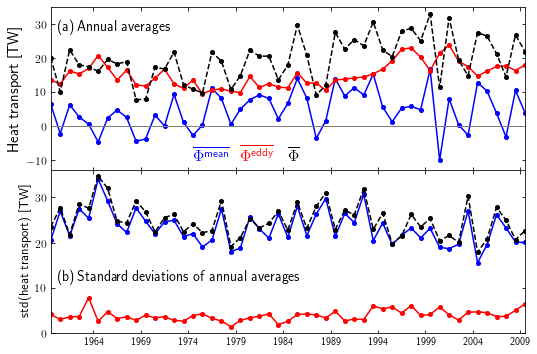

In [19]:
########################################################
# Plot Figure S7 (time series of the annually-averaged #
# mean/eddy/total heat transports and their standard   #
# deviations.                                          #
########################################################

fig7, ax = plt.subplots(nrows=2, sharex=True, figsize=figsize_phis)

xletter, yletter = 0.015, 0.85
# a) Time series of yearly-averaged circumpolar heat transports.
ax[0].plot(tb, yruqxm, color='b', marker='o', ms=4, mfc='b', mec='b', label=r'$\overline{\Phi^\text{mean}}$')
ax[0].plot(tb, yruqxe, color='r', marker='o', ms=4, mfc='r', mec='r', label=r'$\overline{\Phi^\text{eddy}}$')
ax[0].plot(tb, yruqx, color='k', linestyle='dashed', marker='o', ms=4, mfc='k', mec='k', label=r'$\overline{\Phi}$')

# a) Standard deviations.
ax[1].plot(tb, yruqxm_std, color='b', marker='o', ms=4, mfc='b', mec='b')
ax[1].plot(tb, yruqxe_std, color='r', marker='o', ms=4, mfc='r', mec='r')
ax[1].plot(tb, yruqx_std, color='k', linestyle='dashed', marker='o', ms=4, mfc='k', mec='k')

ax[0].axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax[1].axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax[0].set_ylabel(r"Heat transport [TW]", fontsize=15, fontweight='black')
ax[1].set_ylabel(r"std(heat transport) [TW]", fontsize=13, fontweight='black')
ax[0].set_xlim((tb[0], tb[-1]))
ax[0].set_ylim((-13, 35))
ax[1].set_ylim((0, 36))
ax[0].set_yticks(np.arange(-10, 40, 10))
ax[1].set_yticks(np.arange(0, 40, 10))
ax[0].grid(False)
ax[1].grid(False)
ax[0].yaxis.set_tick_params(labelsize=12)
ax[1].yaxis.set_tick_params(labelsize=12)
ax[0].text(xletter, yletter, r'(a)', fontsize=14, fontweight='bold', transform=ax[0].transAxes)
ax[0].text(xletter+0.04, yletter, r'Annual averages', fontsize=14, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(xletter, 0.32, r'(b)', fontsize=14, fontweight='bold', transform=ax[1].transAxes)
ax[1].text(xletter+0.04, 0.32, r'Standard deviations of annual averages', fontsize=14, fontweight='bold', transform=ax[1].transAxes)

dtxt = 0.38
kwtxt7 = dict(fontsize=16, fontweight='black', transform=ax[0].transAxes)
ax[0].text(0.3, 0.05, r'$\overline{\Phi^\text{mean}}$', color='b', **kwtxt7)
ax[0].text(0.4, 0.05, r'$\overline{\Phi^\text{eddy}}$', color='r', **kwtxt7)
ax[0].text(0.5, 0.05, r'$\overline{\Phi}$', color='k', **kwtxt7)

ax[0].xaxis.set_tick_params(labeltop='off', labelbottom='off')
ax[1].xaxis.set_tick_params(labelbottom='on', labeltop='off')
fig7.subplots_adjust(hspace=0)
plt.draw()

fig7.savefig('figS_interannual_stds.eps')
fig7.savefig('figS_interannual_stds.png')

In [20]:
# Get climatologies of circumpolatly-integrated/averaged variables.
fnames = ['tauxy.npz', 'Jb.npz', 'gradRHO.npz', 'EKE_MKE.npz']
vnames = ['tau_alongmo', 'Jbmonthly', 'gradrho_mag_monthly', 'ekemonthly']
for fname, v in zip(fnames, vnames):
    if 'clm' in v: # tauxclm and tauyclm
        try:
            vv = np.load(headnpz+fname)[v].flatten()[0]
        except FileNotFoundError:
            vv = np.load(headnpz+'large_files/'+fname)[v].flatten()[0]
    else:
        try:
            vv = np.load(headnpz+fname)[v]
        except FileNotFoundError:
            vv = np.load(headnpz+'large_files/'+fname)[v]
    vars().update({v:vv})

ddd = np.load(headnpz+'large_files/'+fnames[0])
xm, ym, dm, dist = ddd['xm'], ddd['ym'], ddd['dm'], ddd['d']

In [21]:
# Circumpolarly-integrated Ekman pumping time series.
rho0 = 1025.     # [kg/m3].
fcirc = fcor(ym) # [1/s].

dxm = (dist[1:] - dist[:-1])*1e3 # [m].
dxm = dxm[np.newaxis, ...]

# Wek > 0 means net volume LOSS (divergence, offshore transport due to weaker Easterlies/stronger Westerlies).
wek = -tau_alongmo*dxm/(rho0*fcirc)
Wek = np.sum(wek, axis=1)*1e-6 # [Sv].

ekemonthly = ekemonthly/(cm2m**2)              # back to [cm2/m2].
ekemonthly = np.ma.masked_invalid(ekemonthly)

# Circumpolarly-averaged buoyancy flux time series.
Lxm = dxm.sum()
thresh = 1e3
Jbmonthly[np.abs(Jbmonthly)>thresh] = np.nan
Jbmo = 0.5*(Jbmonthly[:,1:] + Jbmonthly[:,:-1])
ekemo = 0.5*(ekemonthly[:,1:] + ekemonthly[:,:-1])

grhomo = 0.5*(gradrho_mag_monthly[:,1:] + gradrho_mag_monthly[:,:-1])
grhot = np.nansum(grhomo*dxm, axis=1)/Lxm
Jbt = np.nansum(Jbmo*dxm, axis=1)/Lxm
eket = np.nansum(ekemo*dxm, axis=1)/Lxm

In [22]:
# Calculate annual averages and climatologies.
_, yrgrhot, _ = blkavgt(t, grhot, every=12)
_, yrJbt, _ = blkavgt(t, Jbt, every=12)
_, yreket, _ = blkavgt(t, eket, every=12)
_, yrWek, _ = blkavgt(t, Wek, every=12)

grhoclm, grhoclm_std = seasonal_avg(t, grhot), seasonal_std(t, grhot)
Jbclm, Jbclm_std = seasonal_avg(t, Jbt), seasonal_std(t, Jbt)
grhoclm, grhoclm_std = seasonal_avg(t, grhot), seasonal_std(t, grhot)
ekeclm, ekeclm_std = seasonal_avg(t, eket), seasonal_std(t, eket)

uqxclm, uqxclm_std = seasonal_avg(t, uqx), seasonal_std(t, uqx)
uqxmclm, uqxmclm_std = seasonal_avg(t, uqxm), seasonal_std(t, uqxm)
uqxeclm, uqxeclm_std = seasonal_avg(t, uqxe), seasonal_std(t, uqxe)
Wekclm, Wekclm_std = seasonal_avg(t, Wek), seasonal_std(t, Wek)

In [23]:
#############################################
# Calculate standard errors of the mean for # 
# EKE, grad(rho), WEk and UQx/UQm/UQe.      #
#############################################
Ndof = t.size/12 # Number of samples of each month (51). Assuming integral timescale is less than a year (accurate).
sqrtNdof = np.sqrt(Ndof)

# 95 % confidence envelopes.
SE95uqxclm = 2*uqxclm_std/sqrtNdof
SE95uqxmclm = 2*uqxmclm_std/sqrtNdof
SE95uqxeclm = 2*uqxeclm_std/sqrtNdof
SE95ekeclm = 2*ekeclm_std/sqrtNdof
SE95Wekclm = 2*Wekclm_std/sqrtNdof
SE95grhoclm = 2*grhoclm_std/sqrtNdof
SE95Jbclm = 2*Jbclm_std/sqrtNdof

# Read in potential temperature psimean and psieddy.
fT = head + 'Tcirc_tavg.npz'
fpsi = head + 'psimean_psieddy_circavg.npz'
dpsi = np.load(fpsi)
zm = dpsi['zm_full']
psim = dpsi['psimean']
psie = dpsi['psieddy'] # Starts at second W-cell (zw1 = -10 m)
zpsim = dpsi['zm_psimean']
zpsie = dpsi['zm_psieddy'][1:] # Exclude top cell (zw0 = 0).
dzpsi = np.diff(psim.mean(axis=0))
kcap = np.sum(dzpsi!=0) # Index of deepest cell (+1).

Umpsi = psim[:,-1]     # [m3/s].
Uepsi = psie[:,-1]     # [m2/s].
Umnet = Umpsi*1e-6     # [Sv]
Uenet = Uepsi*Lxm*1e-6 # [Sv]
print("")
print("Um net (time-mean) = %.2f Sv"%Umnet.mean())
print("Ue net (time-mean) = %.2f Sv"%Uenet.mean())


Um net (time-mean) = 0.26 Sv
Ue net (time-mean) = 0.02 Sv


In [24]:
# Get dxm, Lxm and DZTm.
dxm = DYU[Im,Jm]*Umskm + DXU[Im,Jm]*Vmskm # Along-isobath distance (zig-zag).
dxm = np.abs(dxm)
Lxm = dxm.sum() # Total isobath length.
DZTm = np.nansum(dztm*dxm, axis=1)/Lxm
DZTm_1pp1 = DZTm[1:-1]

# Recalculate uQx_stir from psie.
psie = psie*Lxm # [m3/s].

dpsiedz = (psie[:,:-1] - psie[:,1:])/DZTm_1pp1 # Back to T-points (with [1:-1] cap).
ue = -dpsiedz # [m/s]. ueddy = ueddy(y,z) or ueddy = ueddy(z).
dTm = np.load(fT)
Tmx_1pp1 = dTm['Tm']
TmTf0 = Tmx_1pp1 - Tf0 # Potential temperatures here.
TmTf0 = TmTf0[:,:kcap]
TmTf0[TmTf0<0.] = 0.

ue = ue[:,:kcap]

# **** NOTE: Removed the Lx factor because already multiplied psie by it above. *$*$*$*$*$*$*$*$*$*$*$*$*$*$
uqxe_adv = np.sum(ue*TmTf0*DZTm_1pp1[:kcap], axis=1)*T2Q # [(degC*m3/s)*T2Q] ---> [TW].

psim = psim[:,:kcap]
psie = psie[:,:kcap]
zpsim = zpsim[:kcap]
zpsie = zpsie[:kcap]

In [25]:
# Time-integrated transports.
dtd = np.diff(t) # [days].
dt = np.array([dtt.total_seconds() for dtt in dtd]) # [s].
uqxm2 = 0.5*(uqxm[1:] + uqxm[:-1])
uqxe2 = 0.5*(uqxe[1:] + uqxe[:-1])
uqx2 = 0.5*(uqx[1:] + uqx[:-1])
it = t[:-1] + dtd/2
T2Y = 1e-9
iuqxm = np.cumsum(uqxm2*dt)*T2Y
iuqxe = np.cumsum(uqxe2*dt)*T2Y
iuqx = np.cumsum(uqx2*dt)*T2Y
print("Time-integrated (1959-2009) and circumpolarly-integrated heat transports:")
print("Mean: %.3f YJ"%iuqxm[-1])
print("Eddy: %.3f YJ"%iuqxe[-1])
print("Total: %.3f YJ"%iuqx[-1])

Time-integrated (1959-2009) and circumpolarly-integrated heat transports:
Mean: 7.167 YJ
Eddy: 24.248 YJ
Total: 31.415 YJ


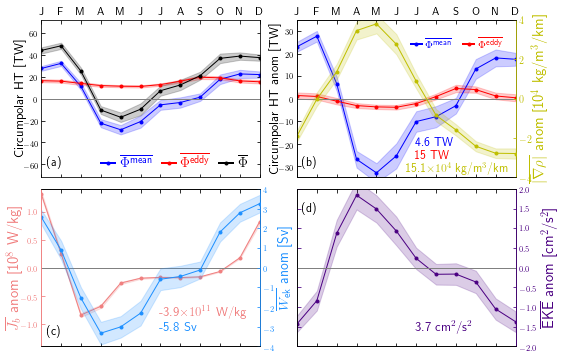

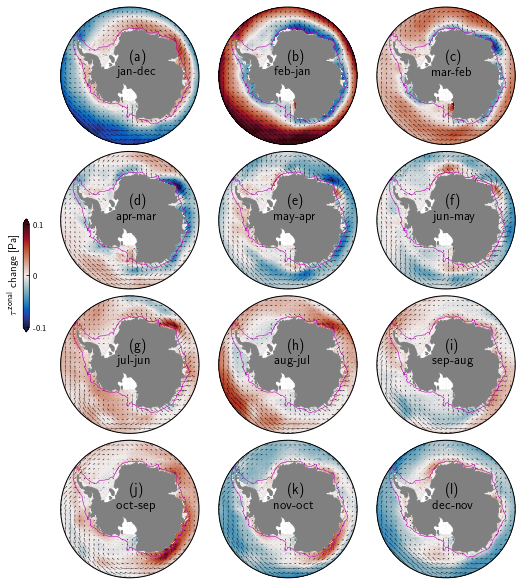

In [26]:
#################################################################
# Plot Figure 6 (seasonal cycles of circumpolarly-integrated or #
# circumpolarly-averaged variables).                            #
#################################################################

icecol = 'darkturquoise'
wekcol = 'dodgerblue'
grhocol = 'y'
jbcol = 'lightcoral'
ekecol = 'indigo'
uqxecol = 'r'
bbox = [-180, 180, -90, -60]
bbox2 = [-180, 180, -90, -65]
xmossn_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
xmossn = np.int32(np.arange(1, 13))

figsize1 = (8.5, 6)
figsize2 = (8.5, 10.5)
subpltshp = (4, 3)

plot_crs = ccrs.SouthPolarStereo()
data_crs = ccrs.PlateCarree()

fig, axs = plt.subplots(figsize=figsize1, nrows=2, ncols=2)
ax1, ax2 = axs[0][0], axs[0][1]
ax3, ax4 = axs[1][0], axs[1][1]

# Separate the maps from the line plots.
fig2 = plt.figure(figsize=figsize2)
gs = gridspec.GridSpec(4, 3)#(3, 4) # This is a container for the bottom 3 rows (maps).

n = 5
for j in range(4):
    for i in range(3):
        axn = fig2.add_subplot(gs[j,i], projection=plot_crs)
        vars().update({'ax'+str(n):axn})
        n+=1

axmaps = [ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16]
_ = [crop_scirc(axn, bbox) for axn in axmaps]

# Mean and eddy transports.
ax1.plot(xmossn, uqxmclm, color='b', linewidth=1.0, marker='o', ms=3, label=r'$\overline{\Phi^\text{mean}}$')
ax1.plot(xmossn, uqxeclm, color='r', linewidth=1.0, marker='o', ms=3, label=r'$\overline{\Phi^\text{eddy}}$')

ax1.plot(xmossn, uqxclm, color='k', label=r'$\overline{\Phi}$', linewidth=1.0, marker='o', ms=3)
ax1.set_ylabel(r"Circumpolar HT [TW]", fontsize=13, fontweight='black', labelpad=-3)
ax1.grid(False)

# Mean and eddy transports (anomalies).
ax2.plot(xmossn, uqxmclm-uqxmclm.mean(), color='b', label=r'$\overline{\Phi^\text{mean}}$', linewidth=1.0, marker='o', ms=3)
ax2.plot(xmossn, uqxeclm-uqxeclm.mean(), color='r', label=r'$\overline{\Phi^\text{eddy}}$', linewidth=1.0, marker='o', ms=3)

ax2.set_ylabel(r"Circumpolar HT anom [TW]", fontsize=13, fontweight='black', labelpad=-3)
ax2.grid(False)

# grad(rho).
axgrho = ax2.twinx()
axgrho.plot(xmossn, (grhoclm-grhoclm.mean())*1e4, color=grhocol, linewidth=1.0, marker='o', ms=3)

axgrho.yaxis.set_tick_params(labelsize=10)
axgrho.grid(False)
axgrho.set_ylabel(r'$\overline{|\boldmath{\nabla}\rho|}$ anom [10$^4$ kg/m$^3$/km]', fontsize=15, fontweight='black', color=grhocol, va='center', labelpad=7)
axgrho.spines['right'].set_color(grhocol)
axgrho.yaxis.set_tick_params(color=grhocol, labelcolor=grhocol, right=True, labelright=True)

# Jb and Wek.
axjb = ax3
axjb.plot(xmossn, (Jbclm-Jbclm.mean())*1e8, color=jbcol, linewidth=1.0, marker='o', ms=3)
axjb.yaxis.set_tick_params(labelsize=10)
axjb.grid(False)
axjb.set_ylabel(r"$\overline{J_b}$ anom [10$^8$ W/kg]", fontsize=15, fontweight='black', color=jbcol, va='center', labelpad=5)
axjb.spines['left'].set_color(jbcol)
axjb.yaxis.set_tick_params(color=jbcol, labelcolor=jbcol, left=True, labelleft=True)

# Circumpolar Ekman divergence.
axWek = ax3.twinx()
axWek.plot(xmossn, Wekclm-Wekclm.mean(), color=wekcol, linewidth=1.0, marker='o', ms=3)
axWek.yaxis.set_tick_params(labelsize=10)
axWek.grid(False)
axWek.set_ylabel(r"$\overline{W_\text{ek}}$ anom [Sv]", fontsize=14, fontweight='black', color=wekcol, va='center', labelpad=12)
axWek.spines['right'].set_color(wekcol)
axWek.yaxis.set_tick_params(color=wekcol, labelcolor=wekcol, right=True, labelright=True)

axWek.spines['left'].set_color(jbcol)

axeke = ax4.twinx()
axeke.plot(xmossn, ekeclm-ekeclm.mean(), color=ekecol, linewidth=1.0, marker='o', ms=3)
axeke.grid(False)
axeke.set_ylabel(r'$\overline{\text{EKE}}$ anom [cm$^2$/s$^2$]', fontsize=15, fontweight='black', color=ekecol, va='center', labelpad=12)
axeke.spines['right'].set_color(ekecol)
axeke.yaxis.set_tick_params(color=ekecol, labelcolor=ekecol, right=True, labelright=True, left=True, labelleft=False)
axeke.grid(False)

ax4.yaxis.set_tick_params(left='off', labelleft='off')

uqxmclm2 = uqxmclm - uqxmclm.mean()
uqxeclm2 = uqxeclm - uqxeclm.mean()
grhoclm2 = (grhoclm - grhoclm.mean())*1e4
Jbclm2 = (Jbclm - Jbclm.mean())*1e8
Wekclm2 = Wekclm - Wekclm.mean()
ekeclm2 = ekeclm - ekeclm.mean()

# 95 % confidence envelopes.
alpha_fill = 0.2
#====================================================================================================================
ax1.fill_between(xmossn, uqxmclm - SE95uqxmclm, y2=(uqxmclm + SE95uqxmclm), color='b', alpha=alpha_fill)
ax1.fill_between(xmossn, uqxeclm - SE95uqxeclm, y2=(uqxeclm + SE95uqxeclm), color='r', alpha=alpha_fill)
ax1.fill_between(xmossn, uqxclm - SE95uqxclm, y2=(uqxclm + SE95uqxclm), color='k', alpha=alpha_fill)
#
ax2.fill_between(xmossn, uqxmclm2 - SE95uqxmclm, y2=(uqxmclm2 + SE95uqxmclm), color='b', alpha=alpha_fill)
ax2.fill_between(xmossn, uqxeclm2 - SE95uqxeclm, y2=(uqxeclm2 + SE95uqxeclm), color='r', alpha=alpha_fill)
axgrho.fill_between(xmossn, grhoclm2 - SE95grhoclm*1e4, y2=(grhoclm2 + SE95grhoclm*1e4), color=grhocol, alpha=alpha_fill)
axjb.fill_between(xmossn, Jbclm2 - SE95Jbclm*1e8, y2=(Jbclm2 + SE95Jbclm*1e8), color=jbcol, alpha=alpha_fill)
axWek.fill_between(xmossn, Wekclm2 - SE95Wekclm, y2=(Wekclm2 + SE95Wekclm), color=wekcol, alpha=alpha_fill)
axeke.fill_between(xmossn, ekeclm2 - SE95ekeclm, y2=(ekeclm2 + SE95ekeclm), color=ekecol, alpha=alpha_fill)
#====================================================================================================================

ax1.set_ylim(-72, 72)
ax2.set_ylim(-35, 35)
axgrho.set_ylim(-4, 4)
axWek.set_ylim(-4, 4)
axjb.set_ylim(-1.4, 1.4)
axeke.set_ylim(-2.0, 2.0)

ax5 = bmap_antarctica_cartopy(ax5, labels=False)
ax6 = bmap_antarctica_cartopy(ax6, labels=False)
ax7 = bmap_antarctica_cartopy(ax7, labels=False)
ax8 = bmap_antarctica_cartopy(ax8, labels=False)
ax9 = bmap_antarctica_cartopy(ax9, labels=False)
ax10 = bmap_antarctica_cartopy(ax10, labels=False)
ax11 = bmap_antarctica_cartopy(ax11, labels=False)
ax12 = bmap_antarctica_cartopy(ax12, labels=False)
ax13 = bmap_antarctica_cartopy(ax13, labels=False)
ax14 = bmap_antarctica_cartopy(ax14, labels=False)
ax15 = bmap_antarctica_cartopy(ax15, labels=False)
ax16 = bmap_antarctica_cartopy(ax16, labels=False)

kwisobplt = dict(color='m', linewidth=0.5, transform=data_crs)
ax5.plot(xm, ym, **kwisobplt)
ax6.plot(xm, ym, **kwisobplt)
ax7.plot(xm, ym, **kwisobplt)
ax8.plot(xm, ym, **kwisobplt)
ax9.plot(xm, ym, **kwisobplt)
ax10.plot(xm, ym, **kwisobplt)
ax11.plot(xm, ym, **kwisobplt)
ax12.plot(xm, ym, **kwisobplt)
ax13.plot(xm, ym, **kwisobplt)
ax14.plot(xm, ym, **kwisobplt)
ax15.plot(xm, ym, **kwisobplt)
ax16.plot(xm, ym, **kwisobplt)

ftauxy_clim = '../../data_reproduce_figs/large_files/tauxy.npz'
dtauxy = np.load(ftauxy_clim)

tauxc = dtauxy['tauxclm'].flatten()[0]
tauyc = dtauxy['tauyclm'].flatten()[0]

for mo in range(1, 13):
    tauxc.update({mo:_glue_axis1(tauxc[mo], fcut)})
    tauyc.update({mo:_glue_axis1(tauyc[mo], fcut)})

tauxc_bar = tauxc[1]
tauyc_bar = tauyc[1]
_ = np.array([vars().update({'tauxc_bar':(tauxc_bar+tauxc[mo])}) for mo in range(2, 13)])
_ = np.array([vars().update({'tauxc_bar':(tauxc_bar+tauxc[mo])}) for mo in range(2, 13)])
tauxc_bar /= 12
tauyc_bar /= 12

fmo_uqmin = 4 # May, max offshore UQx.
fmo_uqmax = 2 # February, max ONSHORE UQx.
taux_uqmin, tauy_uqmin = tauxc[fmo_uqmin], tauyc[fmo_uqmin]
taux_uqmax, tauy_uqmax = tauxc[fmo_uqmax], tauyc[fmo_uqmax]

tauvlim = 0.1
kwtauplt = dict(cmap=plt.cm.seismic, vmin=-tauvlim, vmax=tauvlim, zorder=1, transform=data_crs)
kwtaupltcmo_balance = dict(cmap=cmo.balance, vmin=-tauvlim, vmax=tauvlim, zorder=1, transform=data_crs)
taux_uqmin = np.ma.masked_invalid(taux_uqmin)
taux_uqmax = np.ma.masked_invalid(taux_uqmax)
dtaux_uqmax_minus_uqmin = taux_uqmax - taux_uqmin
dtauy_uqmax_minus_uqmin = tauy_uqmax - tauy_uqmin

dtauxc = dict()
tauxn_prev = tauxc[12] # December (first entry is January - December).
for n in range(1, 13):
    tauxn = tauxc[n]
    dtauxc[n] = tauxn - tauxn_prev
    tauxn_prev = tauxn

cs5 = ax5.pcolormesh(lonu, latu, dtauxc[1], **kwtaupltcmo_balance)
cs6 = ax6.pcolormesh(lonu, latu, dtauxc[2], **kwtaupltcmo_balance)
cs7 = ax7.pcolormesh(lonu, latu, dtauxc[3], **kwtaupltcmo_balance)
cs8 = ax8.pcolormesh(lonu, latu, dtauxc[4], **kwtaupltcmo_balance)
cs9 = ax9.pcolormesh(lonu, latu, dtauxc[5], **kwtaupltcmo_balance)
cs10 = ax10.pcolormesh(lonu, latu, dtauxc[6], **kwtaupltcmo_balance)
cs11 = ax11.pcolormesh(lonu, latu, dtauxc[7], **kwtaupltcmo_balance)
cs12 = ax12.pcolormesh(lonu, latu, dtauxc[8], **kwtaupltcmo_balance)
cs13 = ax13.pcolormesh(lonu, latu, dtauxc[9], **kwtaupltcmo_balance)
cs14 = ax14.pcolormesh(lonu, latu, dtauxc[10], **kwtaupltcmo_balance)
cs15 = ax15.pcolormesh(lonu, latu, dtauxc[11], **kwtaupltcmo_balance)
cs16 = ax16.pcolormesh(lonu, latu, dtauxc[12], **kwtaupltcmo_balance)

nvecs_regrid = 30
veccol = 'k'
kwquiv = dict(color=veccol, transform=data_crs, regrid_shape=nvecs_regrid, pivot='middle', zorder=2)
quiv5 = ax5.quiver(lonu, latu, tauxc[1], tauyc[1], **kwquiv)
quiv6 = ax6.quiver(lonu, latu, tauxc[2], tauyc[2], **kwquiv)
quiv7 = ax7.quiver(lonu, latu, tauxc[3], tauyc[3], **kwquiv)
quiv8 = ax8.quiver(lonu, latu, tauxc[4], tauyc[4], **kwquiv)
quiv9 = ax9.quiver(lonu, latu, tauxc[5], tauyc[5], **kwquiv)
quiv10 = ax10.quiver(lonu, latu, tauxc[6], tauyc[6], **kwquiv)
quiv11 = ax11.quiver(lonu, latu, tauxc[7], tauyc[7], **kwquiv)
quiv12 = ax12.quiver(lonu, latu, tauxc[8], tauyc[8], **kwquiv)
quiv13 = ax13.quiver(lonu, latu, tauxc[9], tauyc[9], **kwquiv)
quiv14 = ax14.quiver(lonu, latu, tauxc[10], tauyc[10], **kwquiv)
quiv15 = ax15.quiver(lonu, latu, tauxc[11], tauyc[11], **kwquiv)
quiv16 = ax16.quiver(lonu, latu, tauxc[12], tauyc[12], **kwquiv)

# Colorbar.
cbaxes = plt.axes([0.08, 0.45, 0.01, 0.15])
cb = fig.colorbar(mappable=cs5, cax=cbaxes, orientation='vertical', extend='both')
cb.set_ticks([-0.1, 0, 0.1])
cb.set_ticklabels([-0.1, 0, 0.1])
cb.ax.yaxis.set_tick_params(labelsize=8)
cb.ax.yaxis.set_ticks_position('right')
cb.set_label(r"$\tau^\text{zonal}$ change [Pa]", fontsize=11, fontweight='black')
cb.ax.yaxis.set_label_position('left')

bbox2 = [-180, 180, -90, -64]
ax5.set_extent(bbox2, data_crs)
ax6.set_extent(bbox2, data_crs)
ax7.set_extent(bbox2, data_crs)
ax8.set_extent(bbox2, data_crs)
ax9.set_extent(bbox2, data_crs)
ax10.set_extent(bbox2, data_crs)
ax11.set_extent(bbox2, data_crs)
ax12.set_extent(bbox2, data_crs)
ax13.set_extent(bbox2, data_crs)
ax14.set_extent(bbox2, data_crs)
ax15.set_extent(bbox2, data_crs)
ax16.set_extent(bbox2, data_crs)

ax5.gridlines(draw_labels=False, linewidth=0.1)
ax6.gridlines(draw_labels=False, linewidth=0.1)
ax7.gridlines(draw_labels=False, linewidth=0.1)
ax8.gridlines(draw_labels=False, linewidth=0.1)
ax9.gridlines(draw_labels=False, linewidth=0.1)
ax10.gridlines(draw_labels=False, linewidth=0.1)
ax11.gridlines(draw_labels=False, linewidth=0.1)
ax12.gridlines(draw_labels=False, linewidth=0.1)
ax13.gridlines(draw_labels=False, linewidth=0.1)
ax14.gridlines(draw_labels=False, linewidth=0.1)
ax15.gridlines(draw_labels=False, linewidth=0.1)
ax16.gridlines(draw_labels=False, linewidth=0.1)

Months = {1:'jan-dec', 2:'feb-jan', 3:'mar-feb', 4:'apr-mar', 5:'may-apr', 6:'jun-may', 7:'jul-jun', 8:'aug-jul', 9:'sep-aug', 10:'oct-sep', 11:'nov-oct', 12:'dec-nov'}
Letters = {1:'(a)', 2:'(b)', 3:'(c)', 4:'(d)', 5:'(e)', 6:'(f)', 7:'(g)', 8:'(h)', 9:'(i)', 10:'(j)', 11:'(k)', 12:'(l)'}
xt, yt = 0.40, 0.50
xtt, ytt = 0.50, 0.58

for n in range(5, 17):
    axn = vars()['ax'+str(n)]
    axn.text(xt, yt, Months[n-4], fontsize=13, fontweight='bold', zorder=10, transform=axn.transAxes)
    axn.text(xtt, ytt, Letters[n-4], fontsize=14, fontweight='bold', zorder=10, ha='left', va='bottom', transform=axn.transAxes)

ax1.set_xticks(xmossn); ax2.set_xticks(xmossn)
ax1.set_xticklabels(xmossn_labels); ax2.set_xticklabels(xmossn_labels)
ax3.set_xticks(xmossn); ax4.set_xticks(xmossn)
nolabels = [""]*12
ax4.set_xticklabels(nolabels); ax4.set_yticklabels(nolabels)

axl = [ax1, ax2, ax3, ax4, ax5, ax6]
axlcart = [ax1, ax2, ax3, ax4, axeke, axWek, axjb]

_ = [a.yaxis.set_tick_params(labelsize=8) for a in axlcart]
_ = [a.grid(False) for a in axlcart]
ax1.axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax2.axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax3.axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
axeke.axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)

ax1.xaxis.set_tick_params(labelbottom=False, labeltop=True, labelsize=11)
ax2.xaxis.set_tick_params(labelbottom=False, labeltop=True, labelsize=11)
ax3.xaxis.set_tick_params(labelbottom=False, labeltop=False)
ax4.xaxis.set_tick_params(labelbottom=False, labeltop=False)
ax4.yaxis.set_tick_params(left=False, labelleft=False)
axeke.xaxis.set_tick_params(labelbottom=False, labeltop=False)

_ = [a.set_xlim(1, 12) for a in axlcart]
axmaps = [ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16]
_ = [crop_scirc(axn, bbox) for axn in axmaps]

legh = ax1.legend(fontsize=14, loc=(0.25, 0.008), frameon=False, ncol=3, handlelength=1, handletextpad=0.35, columnspacing=0.6)
for legobj, legtxt in zip(legh.legendHandles, legh.get_texts()):
    legobj.set_linewidth(2.0)
    legtxt.set_color(legobj.get_color())

legh = ax2.legend(fontsize=11, loc=(0.50, 0.78), frameon=False, ncol=2, handlelength=1, handletextpad=0.35, columnspacing=1.0)
for legobj, legtxt in zip(legh.legendHandles, legh.get_texts()):
    legobj.set_linewidth(2.0)
    legtxt.set_color(legobj.get_color())

xletter, yletter = 0.02, 0.075
xletterd, yletterd = 0.02, 0.86
ax1.text(xletter, yletter, r'(a)', fontsize=12, fontweight='bold', transform=ax1.transAxes)
ax2.text(xletter, yletter, r'(b)', fontsize=12, fontweight='bold', transform=ax2.transAxes)
ax3.text(xletter, yletter, r'(c)', fontsize=12, fontweight='bold', transform=ax3.transAxes)
ax4.text(xletterd, yletterd, r'(d)', fontsize=12, fontweight='bold', transform=ax4.transAxes)

# Add mean value of anomalies as annotations.
xtb, ytb1, ytb2, ytb3 = 0.54, 0.2, 0.12, 0.04
xtb2 = 0.50
ax2.text(xtb, ytb1, r'%0.1f TW'%uqxmclm.mean(), color='b', fontsize=12, fontweight='bold', transform=ax2.transAxes)
ax2.text(xtb, ytb2, r'%0.0f TW'%uqxeclm.mean(), color='r', fontsize=12, fontweight='bold', transform=ax2.transAxes)
ax2.text(xtb2, ytb3, r'%0.1f$\times 10^4$ kg/m$^3$/km'%(grhoclm.mean()*1e4), color=grhocol, fontsize=12, fontweight='bold', transform=ax2.transAxes)
xtb, ytb1, ytb2 = 0.54, 0.2, 0.1
ax3.text(xtb, ytb1, r'%0.1f$\times 10^{11}$ W/kg'%(Jbclm.mean()*1e11), color=jbcol, fontsize=13, fontweight='bold', transform=ax3.transAxes)
ax3.text(xtb, ytb2, r'%0.1f Sv'%Wekclm.mean(), color=wekcol, fontsize=13, fontweight='bold', transform=ax3.transAxes)
ax4.text(xtb, ytb2, r'%0.1f cm$^2$/s$^2$'%ekeclm.mean(), color=ekecol, fontsize=13, fontweight='bold', transform=ax4.transAxes)

fig.subplots_adjust(hspace=0.075, wspace=0.17)
fig2.subplots_adjust(hspace=0.05, wspace=0.0)

figname = 'fig_seasnisob.%s'%fmt
fig.savefig(figname, bbox_inches='tight', dpi=125)

figname = 'fig_seasntau.%s'%fmt
fig2.savefig(figname, bbox_inches='tight', dpi=150)

Queried r = 0.075 with 231.2 EDoF. It is significant at **0.76** CL.
Queried r = 0.669 with inf EDoF. It is significant at **1.00** CL.


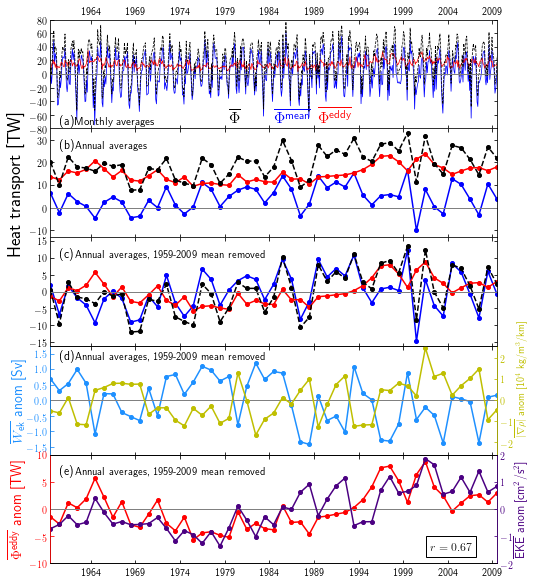

In [27]:
##############################################################
# Plot Figure 7 (inteannual variability of mean/eddy/total   #
# heat transport and other circumpolarly-integrated/averaged #
# variables)                                                 #
##############################################################

fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(8, 10))

# a) Time series of monthly-averaged circumpolar heat transports.
ax[0].plot(t, uqxm, color='b', linewidth=0.75)
ax[0].plot(t, uqxe, color='r', linewidth=0.75)
ax[0].plot(t, uqx, color='k', linestyle='dashed', linewidth=0.75)
ax[0].axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)

# b) Time series of yearly-averaged circumpolar heat transports.
ax[1].plot(tb, yruqxm, color='b', marker='o', ms=4, mfc='b', mec='b')
ax[1].plot(tb, yruqxe, color='r', marker='o', ms=4, mfc='r', mec='r')
ax[1].plot(tb, yruqx, color='k', linestyle='dashed', marker='o', ms=4, mfc='k', mec='k')
ax[1].axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)

# b) Time series of yearly-averaged circumpolar heat transports (seasonal component removed).
# b) Time series of yearly-averaged circumpolar heat transports (1959-2009 mean removed).
yruqxm_anom = yruqxm - yruqxm.mean()
yruqxe_anom = yruqxe - yruqxe.mean()
yruqx_anom = yruqxm_anom + yruqxe_anom
ax[2].plot(tb, yruqxm_anom, color='b', marker='o', ms=4, mfc='b', mec='b')
ax[2].plot(tb, yruqxe_anom, color='r', marker='o', ms=4, mfc='r', mec='r')
ax[2].plot(tb, yruqx_anom, color='k', linestyle='dashed', marker='o', ms=4, mfc='k', mec='k')
ax[2].axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)

## c) Time series of EKE, grad(rho), tau, Jb.
ax3a = ax[3].twinx()
ax3a.plot(tb, (yrgrhot-yrgrhot.mean())*1e4, color=grhocol, marker='o', ms=4, mfc=grhocol, mec=grhocol)
ax[3].plot(tb, yrWek-yrWek.mean(), color=wekcol, marker='o', ms=4, mfc=wekcol, mec=wekcol)
ax[3].axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)

ax[4].plot(tb, yruqxe_anom, color=uqxecol, marker='o', ms=4, mfc=uqxecol, mec=uqxecol, label=r'$\overline{\Phi^\text{eddy}}$')
ax[4].axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax4a = ax[4].twinx()
ax4a.plot(tb, yreket-yreket.mean(), color=ekecol, marker='o', ms=4, mfc=ekecol, mec=ekecol)

ax[1].set_ylabel(r"Heat transport [TW]", fontsize=18, fontweight='black')
ax[3].set_ylabel(r"$\overline{W_\text{ek}}$ anom [Sv]", fontsize=14, fontweight='black', color=wekcol, va='center', labelpad=6)
ax[3].yaxis.set_tick_params(color=wekcol, labelcolor=wekcol, left=True, labelleft=True, right=False, labelright=False)
ax3a.set_ylabel(r'$\overline{|\boldmath{\nabla}\rho|}$ anom [10$^4$ kg/m$^3$/km]', fontsize=10, fontweight='black', color=grhocol, va='center', labelpad=8, y=0.7)
ax3a.yaxis.set_tick_params(color=grhocol, labelcolor=grhocol, right=True, labelright=True)
ax3a.spines['right'].set_color(grhocol)
ax3a.spines['left'].set_color(wekcol)

ax[4].set_ylabel(r"$\overline{\Phi^\text{eddy}}$ anom [TW]", fontsize=14, fontweight='black', color='r')

ryrUQxeEKE = rcoeff(yreket, yruqxe)
r0 = ryrUQxeEKE

kww = dict(nblks=15, ret_median=True, verbose=False)
kwwyr = dict(nblks=5, ret_median=True, verbose=False)
arsig(rcoeff(eket, uqxe), eket.size, Tdecorrw(eket, **kww), Tdecorrw(uqxe, **kww))
arsig(rcoeff(yreket, yruqxe), yreket.size, Tdecorrw(yreket, **kww), Tdecorrw(yruqxe, **kww))

xcorrannot, ycorrannot = 0.85, 0.125
ax[4].text(xcorrannot, ycorrannot, r'$r = %.2f$'%ryrUQxeEKE, fontsize=12, fontweight='black', bbox=dict(facecolor='none', edgecolor='k'), transform=ax[4].transAxes)
ax4a.set_ylabel(r'$\overline{\text{EKE}}$ anom [cm$^2$/s$^2$]', fontsize=12, fontweight='black', color=ekecol, va='center', labelpad=7)
ax4a.spines['right'].set_color(ekecol)
ax4a.spines['left'].set_color(uqxecol)
ax4a.yaxis.set_tick_params(color=ekecol, labelcolor=ekecol, right=True, labelright=True)
ax[4].yaxis.set_tick_params(color=uqxecol, labelcolor=uqxecol, left=True, labelleft=True)

fig.subplots_adjust(hspace=0)#.025)
ax[0].set_xlim((tb[0], tb[-1]))
ax[0].set_ylim((-80, 80))
ax[1].set_xlim((tb[0], tb[-1]))
ax[2].set_xlim((tb[0], tb[-1]))
ax[1].set_ylim((-13, 35))
ax[2].set_ylim((-16, 16))
ax[3].set_ylim((-1.75, 1.75))
ax3a.set_ylim((-2.6, 2.6))
ax[4].set_ylim((-10, 10))
ax4a.set_ylim((-2, 2))

ax[0].set_yticks(np.arange(-80, 100, 20))
ax[1].set_yticks(np.arange(-10, 40, 10))
ax[2].set_yticks(np.arange(-15, 20, 5))
ax[3].set_yticks([-1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax3a.set_yticks([-2, -1, 0, 1, 2])
ax[4].set_yticks(np.arange(-10, 15, 5))
ax4a.set_yticks([-2, -1, 0, 1, 2])
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)
ax[4].grid(False)
ax3a.grid(False)
ax4a.grid(False)

ax[0].axhline(y=0, color='gray', linewidth=1.0, linestyle='-', alpha=1)
ax[0].yaxis.set_tick_params(labelsize=10)
ax[1].yaxis.set_tick_params(labelsize=10)
ax[2].yaxis.set_tick_params(labelsize=10)
ax[3].yaxis.set_tick_params(labelsize=10)
ax[4].yaxis.set_tick_params(labelsize=10)
ax3a.yaxis.set_tick_params(labelsize=10)
ax4a.yaxis.set_tick_params(labelsize=10)

xletter, yletter = 0.02, 0.82
ax[0].text(xletter, 0.04, r'(a)', fontsize=12, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(xletter, yletter, r'(b)', fontsize=12, fontweight='bold', transform=ax[1].transAxes)
ax[2].text(xletter, yletter, r'(c)', fontsize=12, fontweight='bold', transform=ax[2].transAxes)
ax[3].text(xletter, yletter+0.06, r'(d)', fontsize=12, fontweight='bold', transform=ax[3].transAxes)
ax[4].text(xletter, yletter, r'(e)', fontsize=12, fontweight='bold', transform=ax[4].transAxes)

ax[0].text(xletter+0.035, 0.04, r'Monthly averages', fontsize=11, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(xletter+0.035, yletter, r'Annual averages', fontsize=10.5, fontweight='bold', transform=ax[1].transAxes)
ax[2].text(xletter+0.035, yletter, r'Annual averages, 1959-2009 mean removed', fontsize=10.5, fontweight='bold', transform=ax[2].transAxes)
ax[3].text(xletter+0.035, yletter+0.06, r'Annual averages, 1959-2009 mean removed', fontsize=10.5, fontweight='bold', transform=ax[3].transAxes)
ax[4].text(xletter+0.035, yletter, r'Annual averages, 1959-2009 mean removed', fontsize=10.5, fontweight='bold', transform=ax[4].transAxes)

# Annotations.
kwtxt = dict(fontsize=16, fontweight='black', transform=ax[0].transAxes)
ax[0].text(0.40, 0.05, r'$\overline{\Phi}$', color='k', **kwtxt)
ax[0].text(0.50, 0.05, r'$\overline{\Phi^\text{mean}}$', color='b', **kwtxt)
ax[0].text(0.60, 0.05, r'$\overline{\Phi^\text{eddy}}$', color='r', **kwtxt)
ax[0].xaxis.set_tick_params(labeltop='on')

plt.draw()
fig.savefig('figHT_interannual.png', fmt='png', box_inches='tight', dpi=125)
fig.savefig('figHT_interannual.eps', fmt='eps', box_inches='tight')

In [28]:
tplt = tb
tSAM = SAM.index
ftSAM = np.logical_and(t>=datetime(1960, 1, 1, 0), t<=datetime(2009, 11, 30))
ftnino34 = ftSAM.copy()
ftnino34[-1] = True

# Find lag of maximum correlation in the circumpolarly-averaged sense.
Lx2 = 250       # [km], Desired size for each block.
dx = 3.28971284 # [km].
blkx2 = int(Lx2/dx)
davg2, _, _ = blkavg(d, UQx[:,0], every=blkx2)

nblks_SAMUQx = 30

nnn = davg2.size
UQx_avgx2 = np.zeros((t.size,nnn))*np.nan
for m in range(t.size):
    _, UQx_avgx2[m,:], _ = blkavg(d, UQx[m,:], every=blkx2)
UQx_avgx2_capSAM = UQx_avgx2[ftSAM,:]

lagsSAMUQx, _ = crosscorr(SAM.values, UQx_avgx2_capSAM[:,0], nblks_SAMUQx)
xcSAMUQx = np.zeros((lagsSAMUQx.size, nnn))*np.nan
for n in range(nnn):
    _, xcSAMUQx[:,n] = crosscorr(SAM.values, UQx_avgx2_capSAM[:,n], nblks_SAMUQx)

nblks_NINO34UQx = 30
UQx_avgx2_capNINO34 = UQx_avgx2[ftnino34,:]

lagsNINO34UQx, _ = crosscorr(NINO34.values, UQx_avgx2_capNINO34[:,0], nblks_NINO34UQx)
xcNINO34UQx = np.zeros((lagsNINO34UQx.size, nnn))*np.nan
for n in range(nnn):
    _, xcNINO34UQx[:,n] = crosscorr(NINO34.values, UQx_avgx2_capNINO34[:,n], nblks_NINO34UQx)

ftUQx = np.logical_and(t>=datetime(1960, 1, 1), t<=datetime(2009, 11, 30))
UQx_avgx_capSAM = UQx_avgx[ftUQx, :]
NINO34_capSAM = NINO34[:-1] # NINO34 Series does have Dec/2009, cap this month off to calculate the correlation coeff.

##############################################################################################################
# SAM is calculated at zero lag, NINO34 is calculated at 7 months lag (the lag of maximum correlation).
lagsnino34_r0 = 7 #*********************

rSAMUQx = np.array([np.corrcoef(SAM, UQx_avgx_capSAM[:,n])[0][1] for n in range(davg.size)])
rNINO34UQx = np.array([np.corrcoef(NINO34_capSAM[lagsnino34_r0:], UQx_avgx_capSAM[:-lagsnino34_r0,n])[0][1] for n in range(davg.size)])
dxavg = np.gradient(davg)*1e3 # [m]
Lxavg = dxavg.sum()
rSAMUQx_xint = np.cumsum(rSAMUQx*dxavg)
rNINO34UQx_xint = np.cumsum(rNINO34UQx*dxavg)
rSAMUQx_xint = rSAMUQx_xint/np.abs(rSAMUQx_xint).max()          # Make it [-1, 1] to compare with the correlation coeff.
rNINO34UQx_xint = rNINO34UQx_xint/np.abs(rNINO34UQx_xint).max() # Make it [-1, 1] to compare with the correlation coeff.

In [29]:
alpha_UQd = 0.95
alpha_UQd_2 = 0.80

# Calculate UQx autocorrelation as a function of along-isobath distance (SAM).
nblks_UQxacorr = 30
TiUQx = np.zeros(davg.size)*np.nan
TiSAM = Tdecorr(crosscorr(SAM.values, SAM.values, nblks_UQxacorr)[1]).max()
for n in range(davg.size):
    TiUQx[n] = Tdecorr(crosscorr(UQx_avgx[:,n], UQx_avgx[:,n], nblks_UQxacorr, verbose=False)[1]).max()
TiUQx[TiUQx>250] = np.nan
TiUQx[TiUQx==0] = np.nan
TiUQx = Series(TiUQx, index=davg).interpolate().values

pc1, pc2, pc3, pc4 = np.nanpercentile(TiUQx, 25), np.nanpercentile(TiUQx, 50), np.nanpercentile(TiUQx, 75), np.nanpercentile(TiUQx, 90)
print("SAM integral timescale:   %1.2f months"%TiSAM)
print("UQx 25%%, median, 75%%, 90%% integral timescales:   %1.2f  %1.2f  %1.2f  %1.2f  months"%(pc1, pc2, pc3, pc4))

pc1d, pc2d, pc3d, pc4d = SAM.size/pc1, SAM.size/pc2, SAM.size/pc3, SAM.size/pc4
print("UQx 25%%, median, 75%%, 90%% EDoFs:   %1.2f  %1.2f  %1.2f  %1.2f  DoFs"%(pc1d, pc2d, pc3d, pc4d))
print("UQx 25%%, median, 75%%, 90%% Minimum significant correlations at %1.2f conf int:   %1.2f  %1.2f  %1.2f  %1.2f"%(alpha_UQd, rsig(pc1d, alpha=alpha_UQd), rsig(pc2d, alpha=alpha_UQd), rsig(pc3d, alpha=alpha_UQd), rsig(pc4d, alpha=alpha_UQd)))

# Calculate UQx autocorrelation as a function of along-isobath distance (NINO34).
TiUQdnino34 = np.zeros(davg.size)*np.nan
TiNINO34 = Tdecorr(crosscorr(NINO34.values, NINO34.values, nblks_UQxacorr)[1]).max()
TiUQdnino34[TiUQdnino34>250] = np.nan
TiUQdnino34[TiUQdnino34==0] = np.nan
TiUQdnino34 = Series(TiUQdnino34, index=davg).interpolate().values

pc1, pc2, pc3, pc4 = np.nanpercentile(TiUQdnino34, 25), np.nanpercentile(TiUQdnino34, 50), np.nanpercentile(TiUQdnino34, 75), np.nanpercentile(TiUQdnino34, 90)
print("NINO34 integral timescale:   %1.2f months"%TiNINO34)
print("UQx 25%%, median, 75%%, 90%% integral timescales:   %1.2f  %1.2f  %1.2f  %1.2f  months"%(pc1, pc2, pc3, pc4))

pc1d, pc2d, pc3d, pc4d = NINO34.size/pc1, NINO34.size/pc2, NINO34.size/pc3, NINO34.size/pc4
print("UQx 25%%, median, 75%%, 90%% EDoFs:   %1.2f  %1.2f  %1.2f  %1.2f  DoFs"%(pc1d, pc2d, pc3d, pc4d))
print("UQx 25%%, median, 75%%, 90%% Minimum significant correlations at %1.2f conf int:   %1.2f  %1.2f  %1.2f  %1.2f"%(alpha_UQd, rsig(pc1d, alpha=alpha_UQd), rsig(pc2d, alpha=alpha_UQd), rsig(pc3d, alpha=alpha_UQd), rsig(pc4d, alpha=alpha_UQd)))

# Integral timescale of total HT is > 1-2 months almost everywhere (plot TiUQx to see).
rsigUQdsam = rsig(SAM.size/TiUQx, alpha=alpha_UQd)
rsigUQdnino34 = rsig(NINO34.size/TiUQx, alpha=alpha_UQd)
rsigUQdsam_2 = rsig(SAM.size/TiUQx, alpha=alpha_UQd_2)
rsigUQdnino34_2 = rsig(NINO34.size/TiUQx, alpha=alpha_UQd_2)
frsig_sam = np.logical_or(rSAMUQx>=rsigUQdsam, rSAMUQx<=-rsigUQdsam)
frsig_sam_2 = np.logical_or(rSAMUQx>=rsigUQdsam_2, rSAMUQx<=-rsigUQdsam_2)
frsig_nino34 = np.logical_or(rNINO34UQx>=rsigUQdnino34, rNINO34UQx<=-rsigUQdnino34)
frsig_nino34_2 = np.logical_or(rNINO34UQx>=rsigUQdnino34_2, rNINO34UQx<=-rsigUQdnino34_2)
frsig_sam_2 = np.logical_and(frsig_sam_2, ~frsig_sam)
frsig_nino34_2 = np.logical_and(frsig_nino34_2, ~frsig_nino34)

SAM integral timescale:   0.84 months
UQx 25%, median, 75%, 90% integral timescales:   5.58  10.26  18.85  35.93  months
UQx 25%, median, 75%, 90% EDoFs:   107.37  58.39  31.77  16.67  DoFs
UQx 25%, median, 75%, 90% Minimum significant correlations at 0.95 conf int:   0.19  0.26  0.35  0.48
NINO34 integral timescale:   2.32 months
UQx 25%, median, 75%, 90% integral timescales:   nan  nan  nan  nan  months
UQx 25%, median, 75%, 90% EDoFs:   nan  nan  nan  nan  DoFs
UQx 25%, median, 75%, 90% Minimum significant correlations at 0.95 conf int:   nan  nan  nan  nan


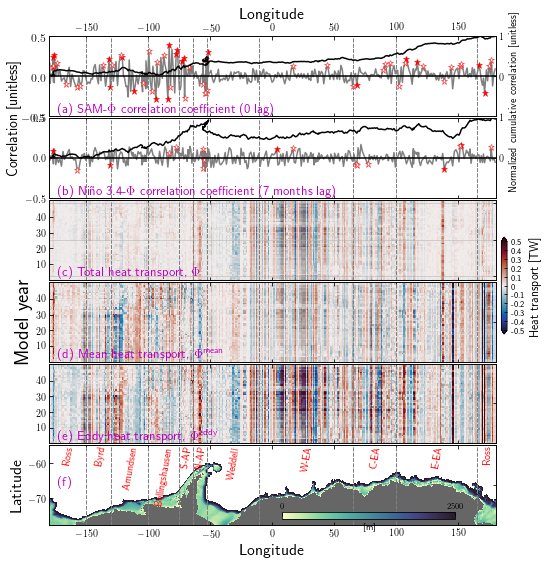

In [30]:
###########################################################
# Figure 9 (x-t diagrams and correlation coefficients     #
# between SAM or Niño 3.4 and the total cross-isobath     #
# heat transport as a function of along-isobath distance. #
###########################################################

fig, ax = plt.subplots(nrows=6, sharex=True, figsize=(8,9))
ax[0].plot(xavg, rSAMUQx, color='gray', linestyle='-')
ax[1].plot(xavg, rNINO34UQx, color='gray', linestyle='-')

# Higher confidence level (95 %, filled stars).
ax[0].plot(xavg[frsig_sam], rSAMUQx[frsig_sam], linestyle='none', marker='*', ms=7, mew=0.5, mfc='r', mec='r')
ax[1].plot(xavg[frsig_nino34], rNINO34UQx[frsig_nino34], linestyle='none', marker='*', ms=7, mew=0.5, mfc='r', mec='r')
# Lower confidence level (80 %, open stars).
ax[0].plot(xavg[frsig_sam_2], rSAMUQx[frsig_sam_2], linestyle='none', marker='*', ms=7, mew=0.5, mfc='w', mec='r')
ax[1].plot(xavg[frsig_nino34_2], rNINO34UQx[frsig_nino34_2], linestyle='none', marker='*', ms=7, mew=0.5, mfc='w', mec='r')

xzero = x*0
ax0dummy = ax[0].twinx()
ax01dummy = ax[1].twinx()
ax1dummy = ax[2].twinx()
ax2dummy = ax[3].twinx()
ax3dummy = ax[4].twinx()
ax4dummy = ax[5].twinx()

ax0dummy.plot(xavg, rSAMUQx_xint, color='k', linestyle='-')
ax01dummy.plot(xavg, rNINO34UQx_xint, color='k', linestyle='-')

cs1 = ax[2].pcolormesh(xavg, np.arange(tplt.size), yrUQx_avgx, vmin=vmim, vmax=vmam, cmap=cmo.balance)
cs2 = ax[3].pcolormesh(xavg, np.arange(tplt.size), yrUQxm_avgx, vmin=vmim, vmax=vmam, cmap=cmo.balance)
cs3 = ax[4].pcolormesh(xavg, np.arange(tplt.size), yrUQxe_avgx, vmin=vmim, vmax=vmam, cmap=cmo.balance)

# Colorbar.
cbtks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
cbaxes = plt.axes([0.91, 0.42, 0.01, 0.15])
cb = fig.colorbar(mappable=cs2, cax=cbaxes, orientation='vertical', extend='both')
cb.set_ticks(cbtks)
cb.set_ticklabels(cbtks)
cb.ax.yaxis.set_tick_params(labelsize=8)
cb.ax.yaxis.set_ticks_position('right')
cb.set_label(r"Heat transport [TW]", fontsize=12, fontweight='black')
cb.ax.yaxis.set_label_position('right')

# Mask deeper than 2500.
htdeep = 2500 #1000
fmsk = head + 'volmsk%dm.npz'%htdeep
mskdeep = ~np.bool8(np.load(fmsk)['volmsk'])
mskdeep = _glue_axis1(mskdeep, fcut)
ht = np.ma.masked_where(mskdeep, ht)
ht[ht==0] = -1

# Plot model bottom topography.
dmin, dmax = 0, htdeep
dtk = 2500
cs = ax[5].pcolormesh(lont, latt, ht, cmap=cmo.deep, vmin=0, vmax=htdeep, zorder=-9)
cs.cmap.set_under(color=[0.4]*3) # Mask land.
cbaxes = fig.add_axes([0.53, 0.135, 0.30, 0.010])
cb = plt.colorbar(mappable=cs, cax=cbaxes, orientation='horizontal')#, extend='max')
cb.set_ticks(np.arange(dmin, dmax+dtk, dtk))
cb.ax.xaxis.set_tick_params(labelsize=8, pad=2)
cb.ax.xaxis.set_ticks_position('top')
cb.set_label(r'[m]', fontsize=9, fontweight='normal')

ax[0].xaxis.set_label_position('top')
ax[0].set_xlabel(r"Longitude", fontsize=16, fontweight='black')
ax[5].set_xlabel(r"Longitude", fontsize=16, fontweight='black')
ax[5].set_ylabel(r"Latitude", fontsize=16, fontweight='black')

xletter, yletter = 0.02, 0.05
ax[0].text(xletter, yletter, r'(a) SAM-$\Phi$ correlation coefficient (0 lag)', fontsize=13, color='m', fontweight='bold', transform=ax[0].transAxes)
ax[1].text(xletter, yletter, r'(b) Niño 3.4-$\Phi$ correlation coefficient (%d months lag)'%lagsnino34_r0, fontsize=13, color='m', fontweight='bold', transform=ax[1].transAxes)
ax[2].text(xletter, yletter, r'(c) Total heat transport, $\Phi$', fontsize=13, color='m', fontweight='bold', transform=ax[2].transAxes)
ax[3].text(xletter, yletter, r'(d) Mean heat transport, $\Phi^\text{mean}$', fontsize=13, color='m', fontweight='bold', transform=ax[3].transAxes)
ax[4].text(xletter, yletter, r'(e) Eddy heat transport, $\Phi^\text{eddy}$', fontsize=13, color='m', fontweight='bold', transform=ax[4].transAxes)
ax[5].text(xletter, 0.5, r'(f)', fontsize=13, color='m', fontweight='bold', transform=ax[5].transAxes)

ax[0].yaxis.set_ticks([-0.5, 0, 0.5])
ax[1].yaxis.set_ticks([-0.5, 0, 0.5])
ax0dummy.yaxis.set_ticks([0, 1])
ax01dummy.yaxis.set_ticks([0, 1])
ax[1].xaxis.set_tick_params(labeltop=False)
ax[2].xaxis.set_tick_params(labeltop=False)
ax[3].xaxis.set_tick_params(labeltop=False)
ax[4].xaxis.set_tick_params(labeltop=False)
ax[5].xaxis.set_tick_params(labeltop=False)
ax[0].yaxis.set_tick_params(labelsize=12)

ax0dummy.plot(x, xzero, linestyle='none')
ax1dummy.plot(x, xzero, linestyle='none')
ax0dummy.axhline(color='k', linestyle='-')
ax01dummy.axhline(color='k', linestyle='-')
ax0dummy.set_ylim((-1, 1))
ax01dummy.set_ylim((-1, 1))
ax0dummy.set_xlim((xavg[0], xavg[-1]))
ax01dummy.set_xlim((xavg[0], xavg[-1]))
ax[0].set_ylim((-0.5, 0.5))
ax[1].set_ylim((-0.5, 0.5))
ax[2].set_ylim((0, 51))
ax[3].set_ylim((0, 51))
ax[4].set_ylim((0, 51))
ax[2].yaxis.set_ticks([10, 20, 30, 40])
ax[3].yaxis.set_ticks([10, 20, 30, 40])
ax[4].yaxis.set_ticks([10, 20, 30, 40])
ax[1].set_ylabel(r"Correlation [unitless]", fontsize=14, fontweight='black', y=1)
ax01dummy.set_ylabel(r"Normalized cumulative correlation [unitless]", fontsize=10, fontweight='black', y=1.2, labelpad=5)
ax[3].set_ylabel(r"Model year", fontsize=20, fontweight='black')
ax[5].set_ylim((-78, -55))
ax[5].set_xlim((xavg[0], xavg[-1]))
ax[5].set_xlim((-180, 180))

kwvl = dict(color='gray', linestyle='--', linewidth=1.0)
for seg in segs_lims.keys():
    lol, lor = segs_lims[seg][:2]
    ax[0].axvline(x=lol, **kwvl)
    ax[0].axvline(x=lor, **kwvl)
    ax[1].axvline(x=lol, **kwvl)
    ax[1].axvline(x=lor, **kwvl)
    ax[2].axvline(x=lol, **kwvl)
    ax[2].axvline(x=lor, **kwvl)
    ax[3].axvline(x=lol, **kwvl)
    ax[3].axvline(x=lor, **kwvl)
    ax[4].axvline(x=lol, **kwvl)
    ax[4].axvline(x=lor, **kwvl)
    ax[5].axvline(x=lol, **kwvl)
    ax[5].axvline(x=lor, **kwvl)

# Names of segments and longitudes to plot the names.
yt0 = 0.7
yt2 = -57.5
rotation = 80
seg_txts = {r'E-EA':132.5, r'C-EA':82.5, r'Weddell':-32.0, r'Bellingshausen':-87.5, r'W-EA':27.0, r'Ross':-165.0, r'Byrd':-139.5, r'Amundsen':-115.0, r'S-AP':-69.5, r'N-AP':-58.5}
for txt, xtxt in seg_txts.items():
    ax[5].text(xtxt, yt2, txt, fontsize=10, fontweight='demibold', color='r', rotation=rotation, transform=ax[5].transData, ha='center')
    if txt=='Ross':
        ax[5].text(173, yt2, txt, fontsize=10, fontweight='demibold', color='r', rotation=90, transform=ax[5].transData, ha='center')

ax[0].xaxis.set_tick_params(labeltop=True)
ax[1].xaxis.set_tick_params(labeltop=False)
ax[2].xaxis.set_tick_params(labeltop=False)
ax[3].xaxis.set_tick_params(labeltop=False)
ax[4].xaxis.set_tick_params(labeltop=False)
ax[5].xaxis.set_tick_params(labeltop=False)
ax[0].yaxis.set_tick_params(labelright=False)
ax[1].yaxis.set_tick_params(labelright=False)
ax[2].yaxis.set_tick_params(labelright=False)
ax[3].yaxis.set_tick_params(labelright=False)
ax[4].yaxis.set_tick_params(labelright=False)
ax[5].yaxis.set_tick_params(labelright=False)
ax1dummy.xaxis.set_tick_params(labeltop=False)
ax2dummy.xaxis.set_tick_params(labeltop=False)
ax3dummy.xaxis.set_tick_params(labeltop=False)
ax4dummy.xaxis.set_tick_params(labelbottom=False)
ax0dummy.yaxis.set_tick_params(labelright=True)
ax1dummy.yaxis.set_tick_params(labelright=False)
ax2dummy.yaxis.set_tick_params(labelright=False)
ax3dummy.yaxis.set_tick_params(labelright=False)
ax4dummy.yaxis.set_tick_params(labelright=False)

ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)
ax[4].grid(False)
ax[5].grid(False)
ax0dummy.grid(False)
ax01dummy.grid(False)
ax2dummy.grid(False)
ax3dummy.grid(False)
ax4dummy.grid(False)
ax4dummy.grid(False)

fig.subplots_adjust(hspace=0.025)
figname = 'figHT_x-t.png'
fig.savefig(figname, bbox_inches='tight', pad_inches=0.0)

In [31]:
# Circumpolar heat storage and its time derivative.
Qm = Series(Qm, index=t)

tauxx = DatetimeIndex(data=t)
dtauxx = np.gradient(tauxx)
dtausecs = ([Timedelta(dtt).total_seconds() for dtt in dtauxx])
dQmdt = np.gradient(Qm)/dtausecs # [degC/s].
_, dQmdtyr, _ = blkavgt(t, dQmdt, every=12)
nblks_xcorr = nblkssam

lags, xrQmSAM = crosscorr(SAM.values, Qm[ftSAM].values, nblks_xcorr)
_, xrUQxSAM = crosscorr(SAM.values, uqx[ftSAM], nblks_xcorr)
_, rsam_uqxm_circ = crosscorr(SAM.values, uqxm[ftSAM], nblks_xcorr)
_, rsam_uqxe_circ = crosscorr(SAM.values, uqxe[ftSAM], nblks_xcorr)
fmaxQ = np.abs(xrQmSAM).argmax()
fmaxUQx = np.abs(xrUQxSAM).argmax()
fmaxUQxm = np.abs(rsam_uqxm_circ).argmax()
fmaxUQxe = np.abs(rsam_uqxe_circ).argmax()
print("MAX lagged r(SAM <-> Qm)  =  %.2f  at  lag  =  %.1f  years"%(xrQmSAM[fmaxQ], lags[fmaxQ]))
print("MAX lagged r(SAM <-> UQx)  =  %.2f  at  lag  =  %.1f  years"%(xrUQxSAM[fmaxUQx], lags[fmaxUQx]))
print("MAX lagged r(SAM <-> UQxm)  =  %.2f  at  lag  =  %.1f  years"%(rsam_uqxm_circ[fmaxUQxm], lags[fmaxUQxm]))
print("MAX lagged r(SAM <-> UQxe)  =  %.2f  at  lag  =  %.1f  years"%(rsam_uqxe_circ[fmaxUQxe], lags[fmaxUQxe]))

## Calculate correlation between SAM and segment-averaged transports.
# Correlations at 0 lag.
rQmSAM = rcoeff(SAM.values, Qm[ftSAM].values)
rUQSAM = rcoeff(SAM.values, uqx[ftSAM])
rUQmSAM = rcoeff(SAM.values, uqxm[ftSAM])
rUQeSAM = rcoeff(SAM.values, uqxe[ftSAM])

# Lagged correlations.
_, SAMacorr = crosscorr(SAM.values, SAM.values, nblks_xcorr)
_, Qmacorr = crosscorr(Qm, Qm, nblks_xcorr)
_, SAM_Qm_acorr = crosscorr(SAM.values, Qm[ftSAM], nblks_xcorr)

TSAM = Tdecorr(SAMacorr).max()
TQm = Tdecorr(Qmacorr).max()

# Are these correlations significant?
r0 = 0.09
Ndt = SAM.size
T1, T2 = TSAM, TQm

_, yrNINO34, _ = blkavgt(t, NINO34, every=12)
yrNINO34[-1] = NINO34[-11:].mean()
_, yrSAM, _ = blkavgt(t, SAM, every=12)
yrSAM[-1] = SAM[-11:].mean()

# Print monthly and annual zero-lag correlations.
rsqyr = rcoeff(yrSAM, Qmyr)
rsqmo = rcoeff(SAM, Qm[ftSAM])
rnqyr = rcoeff(yrNINO34, Qmyr)
rnqmo = rcoeff(NINO34, Qm[12:])
print("Monthly/yearly SAM - Qm zero-lag correlation coeff: %.3f / %.3f "%(rsqmo, rsqyr))
print("Monthly/yearly Ni~no 3.4 - Qm zero-lag correlation coeff: %.3f / %.3f "%(rnqmo, rnqyr))

_, xrQmSAM = crosscorr(SAM.values, Qm[ftSAM].values, nblks_xcorr)
_, xrUQxSAM = crosscorr(SAM.values, uqx[ftSAM], nblks_xcorr)
_, rsam_uqxm_circ = crosscorr(SAM.values, uqxm[ftSAM], nblks_xcorr)
lagssam, rsam_uqxe_circ = crosscorr(SAM.values, uqxe[ftSAM], nblks_xcorr)
_, rnino34_uqxm_circ = crosscorr(NINO34.values, uqxm[12:], nblks_xcorr)
_, rnino34_uqxe_circ = crosscorr(NINO34.values, uqxe[12:], nblks_xcorr)

# Lagged correlations between SAM and the segment-averaged total heat transports.
xrsegs = dict()
for seg in segnames:
    _, xcorrseg = crosscorr(SAM.values, uqxmseg_avg[seg][ftSAM], nblks_xcorr)
    xrsegs.update({seg:xcorrseg})

MAX lagged r(SAM <-> Qm)  =  -0.23  at  lag  =  -20.0  years
MAX lagged r(SAM <-> UQx)  =  0.22  at  lag  =  -24.0  years
MAX lagged r(SAM <-> UQxm)  =  0.22  at  lag  =  -24.0  years
MAX lagged r(SAM <-> UQxe)  =  -0.20  at  lag  =  22.0  years
Monthly/yearly SAM - Qm zero-lag correlation coeff: 0.221 / 0.681 
Monthly/yearly Ni~no 3.4 - Qm zero-lag correlation coeff: 0.141 / 0.216 


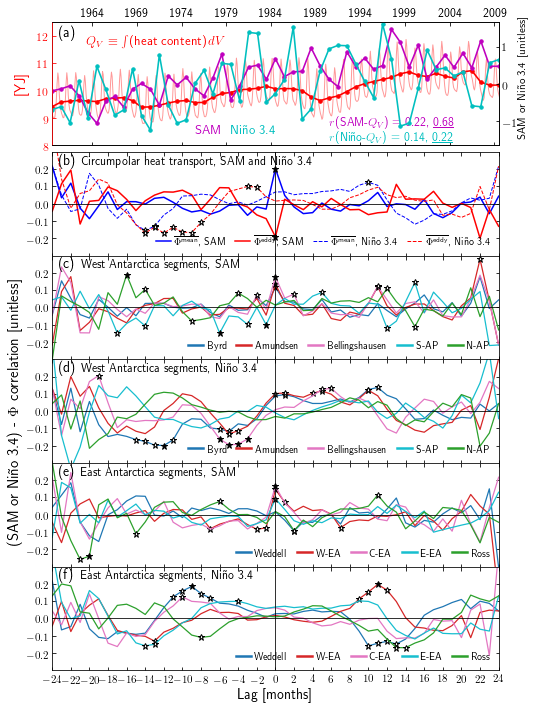

In [32]:
################################################################################
# Plot Figure 10 (lagged correlations between SAM or Niño 3.4                  #
# and the circumpolar and segment-averaged total coss-isobath heat transports) #
################################################################################

dlags = 2
dlshft = 0
NINO34col = 'c'

figseg = plt.figure(figsize=(8,9))

gsupp = gridspec.GridSpec(1, 1)
gsupp.update(top=1, bottom=0.81)
gslow = gridspec.GridSpec(5, 1)
gslow.update(bottom=0, top=0.80, hspace=0)

ax1 = plt.subplot(gsupp[0])
ax2 = plt.subplot(gslow[0])
ax3 = plt.subplot(gslow[1])
ax4 = plt.subplot(gslow[2])
ax5 = plt.subplot(gslow[3])
ax6 = plt.subplot(gslow[4])
ax = np.array([ax1, ax2, ax3, ax4, ax5, ax6], dtype=object)

Qcol = 'r'
SAMcol = 'm'

# d) Circumpolarly-integrated (inshore of 1000 m isobath) heat content and SAM index.
ax[0].plot(t, Qm, Qcol, linewidth=1.0, alpha=0.4)
ax[0].plot(tb, Qmyr, Qcol, linewidth=1.6, marker='o', ms=3.5, mfc=Qcol, mec=Qcol, zorder=-9999)

xaletter1, yaletter1 = 0.075, 0.8
xaletter2, yaletter2 = 0.325, 0.8
xaletter3, yaletter3 = 0.32, 0.10
xaletter32, yaletter32 = 0.40, 0.10
xaletter4, yaletter4 = 0.065, 0.88
ax[0].text(xaletter1, yaletter1, r'$Q_V \equiv \int $(heat content)$ \, dV$', fontsize=13, color=Qcol, fontweight='black', transform=ax[0].transAxes)
ax[0].text(xaletter3, yaletter3, r'SAM', fontsize=13, color=SAMcol, fontweight='black', transform=ax[0].transAxes)
ax[0].text(xaletter32, yaletter32, r'Niño 3.4', fontsize=13, color=NINO34col, fontweight='black', transform=ax[0].transAxes)
ax[1].text(xaletter4, yaletter4, r'Circumpolar heat transport, SAM and Niño 3.4', fontsize=12, color='k', fontweight='black', transform=ax[1].transAxes)
ax[2].text(xaletter4, yaletter4, r'West Antarctica segments, SAM', fontsize=12, color='k', fontweight='black', transform=ax[2].transAxes)
ax[3].text(xaletter4, yaletter4, r'West Antarctica segments, Niño 3.4', fontsize=12, color='k', fontweight='black', transform=ax[3].transAxes)
ax[4].text(xaletter4, yaletter4, r'East Antarctica segments, SAM', fontsize=12, color='k', fontweight='black', transform=ax[4].transAxes)
ax[5].text(xaletter4, yaletter4, r'East Antarctica segments, Niño 3.4', fontsize=12, color='k', fontweight='black', transform=ax[5].transAxes)
ax[0].set_ylabel(r'[YJ]', fontsize=14, fontweight='black', color=Qcol, va='center', labelpad=15)

corrlim = 0.3
rylimtks = 0.2
drylimtks = 0.1
ax[0].grid(False)
ax[0].set_ylim((0, 30))
ax[0].set_xlim((tb[0], tb[-1]))
ax[0].set_ylim((8.5, 12.5))
ax[0].xaxis.set_tick_params(labelsize=12)
ax[0].yaxis.set_tick_params(labelsize=12)
ax[0].yaxis.set_tick_params(color=Qcol, labelcolor=Qcol)

xletter, yletter = 0.015, 0.88
ax[0].text(xletter, yletter, r'(a)', fontsize=14, fontweight='bold', transform=ax[0].transAxes)
ax[1].text(xletter, yletter, r'(b)', fontsize=14, fontweight='bold', transform=ax[1].transAxes)
ax[2].text(xletter, yletter, r'(c)', fontsize=14, fontweight='bold', transform=ax[2].transAxes)
ax[3].text(xletter, yletter, r'(d)', fontsize=14, fontweight='bold', transform=ax[3].transAxes)
ax[4].text(xletter, yletter, r'(e)', fontsize=14, fontweight='bold', transform=ax[4].transAxes)
ax[5].text(xletter, yletter, r'(f)', fontsize=14, fontweight='bold', transform=ax[5].transAxes)
ax[1].xaxis.set_tick_params(labelbottom=False)

ax1sam = ax[0].twinx()
ax1sam.plot(tb, yrSAM, color=SAMcol, linewidth=1.6, marker='o', ms=3.4, mfc=SAMcol, mec=SAMcol, zorder=-9999)
ax1sam.plot(tb, yrNINO34, color=NINO34col, linewidth=1.6, marker='o', ms=3.4, mfc=NINO34col, mec=NINO34col, zorder=-9999)
ax1sam.grid(False)
ax1sam.yaxis.set_tick_params(color='k', labelcolor='k', right=True, labelright=True)
ax1sam.set_ylabel(r"SAM or Niño 3.4 [unitless]", fontsize=11, fontweight='black', color='k', va='center', labelpad=5, y=0.55)
ax1sam.set_ylim(-1.65, 1.65)
ax1sam.yaxis.set_tick_params(labelsize=12)
ax1sam.spines['right'].set_color('k')
ax1sam.spines['left'].set_color(Qcol)

xcorrannot, ycorrannot = 0.62, 0.15
xcorrannot2, ycorrannot2 = 0.62, 0.03
ax[0].text(xcorrannot, ycorrannot, r'$r$(SAM-$Q_V$) = %.2f, \underline{%.2f}'%(rsqmo, rsqyr), color=SAMcol, fontsize=12, fontweight='demibold', transform=ax[0].transAxes, zorder=999999999)
ax[0].text(xcorrannot2, ycorrannot2, r'$r$(Niño-$Q_V$) = %.2f, \underline{%.2f}'%(rnqmo, rnqyr), color=NINO34col, fontsize=12, fontweight='demibold', transform=ax[0].transAxes, zorder=999999999)

ax[0].xaxis.set_tick_params(labelbottom=False, labeltop=True, pad=3)
ax1sam.xaxis.set_tick_params(labelbottom=False, labeltop=True, pad=3)

# Lagged correlation between circumpolarly-integrated transports and SAM.
kwleg00 = dict(fontsize=9, loc='lower center', frameon=False, ncol=5, handlelength=1.5, handletextpad=0.35, columnspacing=1.0)
kwleg001 = {'columnspacing': 1.5, 'fontsize': 12, 'frameon': False, 'handlelength': 1.5, 'handletextpad': 0.35, 'loc':(0.065,-0.03), 'ncol':4}
ax[1].plot(lagssam, rsam_uqxm_circ, linewidth=1.5, color='b', label=r"$\overline{\Phi^\text{mean}}$, SAM")
ax[1].plot(lagssam, rsam_uqxe_circ, linewidth=1.5, color='r', label=r"$\overline{\Phi^\text{eddy}}$, SAM")
ax[1].plot(lagsnino34, rnino34_uqxm_circ, linewidth=1.0, color='b', linestyle='--', label=r"$\overline{\Phi^\text{mean}}$, Niño 3.4")
ax[1].plot(lagsnino34, rnino34_uqxe_circ, linewidth=1.0, color='r', linestyle='--', label=r"$\overline{\Phi^\text{eddy}}$, Niño 3.4")

fsigsamm_circ2 = np.logical_or(rsam_uqxm_circ>=rsig2msam_circ, rsam_uqxm_circ<=-rsig2msam_circ)
fsigsame_circ2 = np.logical_or(rsam_uqxe_circ>=rsig2esam_circ, rsam_uqxe_circ<=-rsig2esam_circ)
fsigsamm_circ1 = np.logical_or(rsam_uqxm_circ>=rsig1msam_circ, rsam_uqxm_circ<=-rsig1msam_circ)
fsigsame_circ1 = np.logical_or(rsam_uqxe_circ>=rsig1esam_circ, rsam_uqxe_circ<=-rsig1esam_circ)
fsigsamm_circ1 = np.logical_and(fsigsamm_circ1, ~fsigsamm_circ2)
fsigsame_circ1 = np.logical_and(fsigsame_circ1, ~fsigsame_circ2)
#
fsignino34m_circ2 = np.logical_or(rnino34_uqxm_circ>=rsig2mnino34_circ, rnino34_uqxm_circ<=-rsig2mnino34_circ)
fsignino34e_circ2 = np.logical_or(rnino34_uqxe_circ>=rsig2enino34_circ, rnino34_uqxe_circ<=-rsig2enino34_circ)
fsignino34m_circ1 = np.logical_or(rnino34_uqxm_circ>=rsig1mnino34_circ, rnino34_uqxm_circ<=-rsig1mnino34_circ)
fsignino34e_circ1 = np.logical_or(rnino34_uqxe_circ>=rsig1enino34_circ, rnino34_uqxe_circ<=-rsig1enino34_circ)
fsignino34m_circ1 = np.logical_and(fsignino34m_circ1, ~fsignino34m_circ2)
fsignino34e_circ1 = np.logical_and(fsignino34e_circ1, ~fsignino34e_circ2)

ax[1].plot(lagssam[fsigsamm_circ2], rsam_uqxm_circ[fsigsamm_circ2], linestyle='none', marker='*', ms=7, mew=1, mfc='k', mec='k')
ax[1].plot(lagssam[fsigsame_circ2], rsam_uqxe_circ[fsigsame_circ2], linestyle='none', marker='*', ms=7, mew=1, mfc='k', mec='k')
ax[1].plot(lagsnino34[fsignino34m_circ1], rnino34_uqxm_circ[fsignino34m_circ1], linestyle='none', marker='*', ms=7, mew=1, mfc='w', mec='k')
ax[1].plot(lagsnino34[fsignino34e_circ1], rnino34_uqxe_circ[fsignino34e_circ1], linestyle='none', marker='*', ms=7, mew=1, mfc='w', mec='k')

for seg in Wsegs:
    rsam_uqxt = Rsam_uqxt[seg]
    rnino34_uqxt = Rnino34_uqxt[seg]

    ax[2].plot(lagssam, rsam_uqxt, linewidth=1.25, label=seg)
    ax[3].plot(lagsnino34, rnino34_uqxt, linewidth=1.25, label=seg)

    # Significant at higher (95%) confidence level.
    fsigsamt2 = np.logical_or(rsam_uqxt>=rsig2tsam[seg], rsam_uqxt<=-rsig2tsam[seg])
    fsignino34t2 = np.logical_or(rnino34_uqxt>=rsig2tnino34[seg], rnino34_uqxt<=-rsig2tnino34[seg])
    fsigsamt1 = np.logical_or(rsam_uqxt>=rsig1tsam[seg], rsam_uqxt<=-rsig1tsam[seg])
    fsignino34t1 = np.logical_or(rnino34_uqxt>=rsig1tnino34[seg], rnino34_uqxt<=-rsig1tnino34[seg])

    fsigsamt1 = np.logical_and(fsigsamt1, ~fsigsamt2)
    fsignino34t1 = np.logical_and(fsignino34t1, ~fsignino34t2)
    ax[2].plot(lagssam[fsigsamt2], rsam_uqxt[fsigsamt2], linestyle='none', ms=7, mew=1, marker='*', mfc='k', mec='k')
    ax[3].plot(lagsnino34[fsignino34t2], rnino34_uqxt[fsignino34t2], linestyle='none', ms=7, mew=1, marker='*', mfc='k', mec='k')

    # Significant at lower (80%) confidence level.
    fsigsamt = np.logical_or(rsam_uqxt>=rsig1tsam[seg], rsam_uqxt<=-rsig1tsam[seg])
    fsignino34t = np.logical_or(rnino34_uqxt>=rsig1tnino34[seg], rnino34_uqxt<=-rsig1tnino34[seg])
    ax[2].plot(lagssam[fsigsamt1], rsam_uqxt[fsigsamt1], linestyle='none', ms=7, mew=1, marker='*', mfc='w', mec='k')
    ax[3].plot(lagsnino34[fsignino34t1], rnino34_uqxt[fsignino34t1], linestyle='none', ms=7, mew=1, marker='*', mfc='w', mec='k')

for seg in Esegs:
    rsam_uqxt = Rsam_uqxt[seg]
    rnino34_uqxt = Rnino34_uqxt[seg]

    ax[4].plot(lagssam, rsam_uqxt, linewidth=1.25, label=seg)
    ax[5].plot(lagsnino34, rnino34_uqxt, linewidth=1.25, label=seg)

    # Significant at higher (95%) confidence level.
    fsigsamt2 = np.logical_or(rsam_uqxt>=rsig2tsam[seg], rsam_uqxt<=-rsig2tsam[seg])
    fsignino34t2 = np.logical_or(rnino34_uqxt>=rsig2tnino34[seg], rnino34_uqxt<=-rsig2tnino34[seg])
    fsigsamt1 = np.logical_or(rsam_uqxt>=rsig1tsam[seg], rsam_uqxt<=-rsig1tsam[seg])
    fsignino34t1 = np.logical_or(rnino34_uqxt>=rsig1tnino34[seg], rnino34_uqxt<=-rsig1tnino34[seg])

    fsigsamt1 = np.logical_and(fsigsamt1, ~fsigsamt2)
    fsignino34t1 = np.logical_and(fsignino34t1, ~fsignino34t2)
    ax[4].plot(lagssam[fsigsamt2], rsam_uqxt[fsigsamt2], linestyle='none', ms=7, mew=1, marker='*', mfc='k', mec='k')
    ax[5].plot(lagsnino34[fsignino34t2], rnino34_uqxt[fsignino34t2], linestyle='none', ms=7, mew=1, marker='*', mfc='k', mec='k')

    # Significant at lower (80%) confidence level.
    fsigsamt = np.logical_or(rsam_uqxt>=rsig1tsam[seg], rsam_uqxt<=-rsig1tsam[seg])
    fsignino34t = np.logical_or(rnino34_uqxt>=rsig1tnino34[seg], rnino34_uqxt<=-rsig1tnino34[seg])
    ax[4].plot(lagssam[fsigsamt1], rsam_uqxt[fsigsamt1], linestyle='none', ms=7, mew=1, marker='*', mfc='w', mec='k')
    ax[5].plot(lagsnino34[fsignino34t1], rnino34_uqxt[fsignino34t1], linestyle='none', ms=7, mew=1, marker='*', mfc='w', mec='k')

ax[1].axhline(y=0, color='k', linewidth=0.8, linestyle='solid', zorder=9999)
ax[1].axvline(x=0, color='k', linewidth=0.8, linestyle='solid', zorder=9999)
ax[2].axhline(y=0, color='k', linewidth=0.8, linestyle='solid', zorder=9999)
ax[2].axvline(x=0, color='k', linewidth=0.8, linestyle='solid', zorder=9999)
ax[3].axhline(y=0, color='k', linewidth=0.8, linestyle='solid', zorder=9999)
ax[3].axvline(x=0, color='k', linewidth=0.8, linestyle='solid', zorder=9999)
ax[4].axhline(y=0, color='k', linewidth=0.8, linestyle='solid', zorder=9999)
ax[4].axvline(x=0, color='k', linewidth=0.8, linestyle='solid', zorder=9999)
ax[5].axhline(y=0, color='k', linewidth=0.8, linestyle='solid', zorder=9999)
ax[5].axvline(x=0, color='k', linewidth=0.8, linestyle='solid', zorder=9999)

ax[1].grid(False)
ax[2].grid(False)
ax[3].grid(False)
ax[4].grid(False)
ax[5].grid(False)
ax[1].set_ylim((-corrlim, corrlim))
ax[2].set_ylim((-corrlim, corrlim))
ax[3].set_ylim((-corrlim, corrlim))
ax[4].set_ylim((-corrlim, corrlim))
ax[5].set_ylim((-corrlim, corrlim))
ax[1].set_xticks(np.arange(lags[0], lags[-1]+dlags, dlags))
ax[2].set_xticks(np.arange(lags[0], lags[-1]+dlags, dlags))
ax[3].set_xticks(np.arange(lags[0], lags[-1]+dlags, dlags))
ax[4].set_xticks(np.arange(lags[0], lags[-1]+dlags, dlags))
ax[5].set_xticks(np.arange(lags[0], lags[-1]+dlags, dlags))
ax[0].set_yticks([8, 9, 10, 11, 12])
ax[1].set_yticks(np.arange(-rylimtks, rylimtks+drylimtks, drylimtks))
ax[2].set_yticks(np.arange(-rylimtks, rylimtks+drylimtks, drylimtks))
ax[3].set_yticks(np.arange(-rylimtks, rylimtks+drylimtks, drylimtks))
ax[4].set_yticks(np.arange(-rylimtks, rylimtks+drylimtks, drylimtks))
ax[5].set_yticks(np.arange(-rylimtks, rylimtks+drylimtks, drylimtks))
ax[5].set_xlabel(r'Lag [months]', fontsize=14, fontweight='black')
ax[1].xaxis.set_tick_params(labelbottom=False)
ax[2].xaxis.set_tick_params(labelbottom=False)
ax[3].xaxis.set_tick_params(labelbottom=False)
ax[4].xaxis.set_tick_params(labelbottom=False)
ax[3].set_ylabel(r'(SAM or Niño 3.4) - $\Phi$ correlation [unitless]', fontsize=15, fontweight='bold')

ax[1].set_xlim(lags[0]+dlshft, lags[-1]-dlshft)
ax[2].set_xlim(lags[0]+dlshft, lags[-1]-dlshft)
ax[3].set_xlim(lags[0]+dlshft, lags[-1]-dlshft)
ax[4].set_xlim(lags[0]+dlshft, lags[-1]-dlshft)
ax[5].set_xlim(lags[0]+dlshft, lags[-1]-dlshft)

leg1 = ax[1].legend(**kwleg002)
leg2 = ax[2].legend(**kwleg002)
leg3 = ax[3].legend(**kwleg002)
leg4 = ax[4].legend(**kwleg002)
leg5 = ax[5].legend(**kwleg002)

for legobj in leg2.legendHandles:
    legobj.set_linewidth(2.5)
for legobj in leg3.legendHandles:
    legobj.set_linewidth(2.5)
for legobj in leg4.legendHandles:
    legobj.set_linewidth(2.5)
for legobj in leg5.legendHandles:
    legobj.set_linewidth(2.5)

ax[1].yaxis.set_tick_params(labelsize=11)
ax[2].yaxis.set_tick_params(labelsize=11)
ax[3].yaxis.set_tick_params(labelsize=11)
ax[4].yaxis.set_tick_params(labelsize=11)
ax[5].yaxis.set_tick_params(labelsize=11)
ax[5].xaxis.set_tick_params(labelsize=11)

lagsl, lagsr = lags.min(), lags.max()
ax[1].set_xlim((lagsl, lagsr))
ax[2].set_xlim((lagsl, lagsr))
ax[3].set_xlim((lagsl, lagsr))
ax[4].set_xlim((lagsl, lagsr))
ax[5].set_xlim((lagsl, lagsr))

figname = 'figsamnino34-phicorr_SAMnchunks%d.png'%nblkssam
figseg.savefig(figname, **kwsavefig)
figname = 'figsamnino34-phicorr_SAMnchunks%d.eps'%nblkssam
kwfighere = dict(fmt='eps', bbox_inches='tight', pad_inches=0.0)
figseg.savefig(figname, **kwfighere)

In [33]:
# Calculate SAM index and heat content integral timescales to
# determine the significance levels of the correlations.
Nblks = 25
maxlags = 25

_, SAMacorr = crosscorr(SAM.values, SAM.values, Nblks)
_, Qmacorr = crosscorr(Qm, Qm, Nblks)
_, SAM_Qm_acorr = crosscorr(SAM.values, Qm[ftSAM], Nblks)

TSAM = Tdecorr(SAMacorr).max()
TQm = Tdecorr(Qmacorr).max()

NDoF1 = SAM.size/np.maximum(TQm, TSAM) # Roughly 162 DoF for SAM-Qm cross-correlation. Slowest-decorrelating variable is Qm with Ti ~= 3.7 months.
rsig_alpha = 0.99
rsig_SAM_Qm = rsig(NDoF1, alpha=rsig_alpha)
print("----> Minimum rsig for SAM-QM at %1.3f = %1.2f"%(rsig_alpha, rsig_SAM_Qm))

Tyruqxe = Tdecorr(crosscorr(yruqxe, yruqxe, Nblks)[1]).max()
Tyreket = Tdecorr(crosscorr(yreket, yreket, Nblks)[1]).max()
NDoF2 = yruqxe.size/np.maximum(Tyruqxe, Tyreket)
rsig_alpha = 0.999
rsig_uqxe_eke = rsig(NDoF2, alpha=rsig_alpha)
print("----> Minimum rsig for yruqxe-yreke at %1.3f = %1.2f"%(rsig_alpha, rsig_uqxe_eke))

----> Minimum rsig for SAM-QM at 0.990 = 0.26
----> Minimum rsig for yruqxe-yreke at 0.999 = 0.00


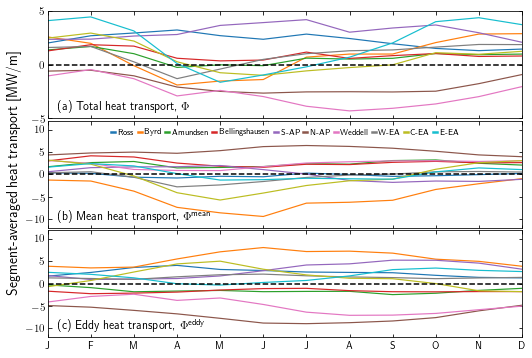

In [34]:
##########################################################
# Plot Figure S3 (seasonal cycle of total, mean and eddy #
# cross-isobath heat transports for all segments.        #
##########################################################

kwlegg_ssn = {'columnspacing': 0.5,
 'fontsize': 8,
 'frameon': False,
 'handlelength': 0.5,
 'handletextpad': 0.3,
 'loc': 'upper center',
 'ncol': 10}

fig, ax = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=figsize_phis)
for seg in segs_lims.keys():
    ax[0].plot(xmossn, seasonal_avg(t, uqxseg_avg[seg]), linewidth=1.2, label=seg)
    ax[1].plot(xmossn, seasonal_avg(t, uqxmseg_avg[seg]), linewidth=1.2, label=seg)
    ax[2].plot(xmossn, seasonal_avg(t, uqxeseg_avg[seg]), linewidth=1.2, label=seg)
ax[0].set_xlim((1, 12))
ax[1].set_xlim((1, 12))
ax[2].set_xlim((1, 12))
ax[0].axhline(color='k', linestyle='--')
ax[1].axhline(color='k', linestyle='--')
ax[2].axhline(color='k', linestyle='--')
leg = ax[1].legend(**kwlegg_ssn)
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.5)
ax[1].set_ylabel(r"Segment-averaged heat transport [MW/m]", fontsize=14, fontweight='black')
ax[2].set_xticks(xmossn)
ax[2].set_xticklabels(xmossn_labels)

ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)
ax[0].set_yticks([-5, 0, 5])
ax[1].set_yticks([-10, -5, 0, 5, 10])
ax[2].set_yticks([-10, -5, 0, 5, 10])
ax[0].set_ylim(-5, 5)
ax[1].set_ylim(-12, 12)
ax[2].set_ylim(-12, 12)

ax[0].yaxis.set_tick_params(labelsize=11, pad=3)
ax[1].yaxis.set_tick_params(labelsize=11, pad=3)
ax[2].yaxis.set_tick_params(labelsize=11, pad=3)

xletter, yletter = 0.02, 0.075
ax[0].text(xletter, yletter, r'(a) Total heat transport, $\Phi$', fontsize=12, color='k', fontweight='black', transform=ax[0].transAxes)
ax[1].text(xletter, yletter, r'(b) Mean heat transport, $\Phi^\text{mean}$', fontsize=12, color='k', fontweight='black', transform=ax[1].transAxes)
ax[2].text(xletter, yletter, r'(c) Eddy heat transport, $\Phi^\text{eddy}$', fontsize=12, color='k', fontweight='black', transform=ax[2].transAxes)

fig.subplots_adjust(hspace=0.02)

plt.draw()
figname = 'fig_segsssn.eps'
figname2 = 'fig_segsssn.png'
kwsavefig_ssn = {'bbox_inches': 'tight', 'fmt': 'eps', 'pad_inches': 0.0}
kwsavefig_ssn2 = {'bbox_inches': 'tight', 'fmt': 'png', 'pad_inches': 0.0}
fig.savefig(figname, **kwsavefig_ssn)
fig.savefig(figname2, **kwsavefig_ssn2)